In [1]:
!pip install -q pandas openpyxl xlrd mlxtend implicit tqdm threadpoolctl matplotlib seaborn

In [2]:
# Cell 2: Core Imports, Constants, Dataclasses, and DataManager Definition (with Recency Weighting)

from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import hashlib
import json
import warnings
import scipy.sparse as sp
from tqdm.auto import tqdm
import implicit
from mlxtend.frequent_patterns import fpgrowth, association_rules
from datetime import datetime, timedelta # timedelta is used
from dataclasses import dataclass, replace as dc_replace

VERBOSE_LOGGING = False

warnings.simplefilter("ignore", pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", message="invalid value encountered", category=RuntimeWarning, module="mlxtend.frequent_patterns.association_rules")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="executing.executing")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ast")

try:
    from threadpoolctl import threadpool_limits
    threadpool_limits(1, "blas")
    if VERBOSE_LOGGING: print("BLAS threadpool limit set to 1.")
except ImportError:
    if VERBOSE_LOGGING: print("Consider 'threadpoolctl' for 'implicit'.")
except Exception as e:
    if VERBOSE_LOGGING: print(f"Could not set BLAS limits: {e}")

# Constants and Paths Configuration
# ----------------------------------------------------------------

CACHE_VERSION_PREFIX = "v1.1" 

# Define the root path for inputs. Assumes the notebook is run from the project root.
INPUT_DATA_DIR = Path("input_datasets/")

# Define paths to the specific dataset files within the input directory.
# The Streamlit app will also use these same paths.
TRAINING_DATA_PATH = INPUT_DATA_DIR / "train_dataset.xlsx"
HOLDOUT_DATA_PATH = INPUT_DATA_DIR / "test_dataset.xlsx"
INVENTORY_DATA_PATH = INPUT_DATA_DIR / "inventory_transactions_clean.xlsx"

# Define the output directory for cached models and rules.
MODELS_OUTPUT_DIR = Path("models")
MODELS_OUTPUT_DIR.mkdir(exist_ok=True) # Ensure the directory exists

ITEM_CLASS_PREFIX = "item_class_"
SKU_NAME_PREFIX = "product_name_"
CUSTOMER_SEGMENT_PREFIXES = {"genre_": "Genre", "slot_": "Slot", "language_": "Language", "rating_": "Rating", "duration_category_": "Duration"}

MIN_SUP = 0.01
MIN_CONF = 0.05
MIN_LIFT = 1.2
MIN_ROWS_SEG = 10
MAX_ROW_REP = 8

RECENCY_WEIGHTING_CONFIG = {
    "apply": True,
    "timestamp_col": "timestamp",
    "tiers": [
        {"months_ago_end": 3, "weight_factor": 1.0},
        {"months_ago_end": 6, "weight_factor": 0.8},
        {"months_ago_end": 12, "weight_factor": 0.6},
        {"months_ago_end": 24, "weight_factor": 0.4},
        {"months_ago_end": float('inf'), "weight_factor": 0.2}
    ]
}

@dataclass
class RuleParams:
    min_support:   float = MIN_SUP
    min_confidence:float = MIN_CONF
    min_lift:      float = MIN_LIFT
    max_len_global:int   = 0
    max_itemset_len_segment: int = 2

@dataclass
class RecParams:
    top_classes: int = 5
    skus_per_cls: int = 3

@dataclass
class EvaluationKValueParam:
    k_for_rank_metrics: int = 10

class DataManager:
    def __init__(self):
        self._df_training_cache = None
        self._df_holdout_cache = None
        self._df_inventory_cache = None
        self._sku_to_class_map = None
        self._class_to_sku_map_training = None
        self._masks_training = None
        self._masks_holdout = None

    def _load_inventory_data(self):
        if self._df_inventory_cache is None:
            if VERBOSE_LOGGING: print(f"Loading inventory data from: {INVENTORY_DATA_PATH}...")
            self._df_inventory_cache = pd.read_excel(INVENTORY_DATA_PATH).drop_duplicates(subset="product_name", keep="first")
        return self._df_inventory_cache

    @property
    def sku2cls(self):
        if self._sku_to_class_map is None:
            inventory_df = self._load_inventory_data()
            if VERBOSE_LOGGING: print("Generating SKU to Item Class mapping...")
            self._sku_to_class_map = inventory_df.set_index("product_name")["item_class"].str.upper().to_dict()
        return self._sku_to_class_map

    def get_class_to_sku_column_mapping_for_df(self, df_source: pd.DataFrame):
        sku_to_class = self.sku2cls
        class_to_sku_cols = {}
        for col_name in df_source.filter(like=SKU_NAME_PREFIX).columns:
            sku_name_only = col_name[len(SKU_NAME_PREFIX):]
            item_class = sku_to_class.get(sku_name_only)
            if item_class is not None: class_to_sku_cols.setdefault(item_class, []).append(col_name)
        return class_to_sku_cols

    def _load_training_with_recency_weights(self) -> pd.DataFrame:
        if self._df_training_cache is None:
            if VERBOSE_LOGGING: print(f"Loading and weighting training data from: {TRAINING_DATA_PATH}...")
            df = pd.read_excel(TRAINING_DATA_PATH, parse_dates=[RECENCY_WEIGHTING_CONFIG["timestamp_col"]])
            if RECENCY_WEIGHTING_CONFIG["timestamp_col"] not in df.columns:
                raise ValueError(f"Training data DataFrame must contain a '{RECENCY_WEIGHTING_CONFIG['timestamp_col']}' column.")

            if RECENCY_WEIGHTING_CONFIG["apply"]:
                ts_col = RECENCY_WEIGHTING_CONFIG["timestamp_col"]
                max_date = df[ts_col].max()
                
                # --- CORRECTED AGE IN MONTHS CALCULATION ---
                # Calculate difference in days, then divide by average days in a month
                days_diff = (max_date - df[ts_col]).dt.days
                df["age_in_months"] = (days_diff / 30.4375).fillna(0).astype(int) # Use average days
                # --- END CORRECTION ---

                df["__recency_weight"] = RECENCY_WEIGHTING_CONFIG["tiers"][-1]["weight_factor"]
                for tier in sorted(RECENCY_WEIGHTING_CONFIG["tiers"], key=lambda x: x["months_ago_end"]):
                    df.loc[df["age_in_months"] < tier["months_ago_end"], "__recency_weight"] = tier["weight_factor"]
                if VERBOSE_LOGGING:
                    print(f"Applied recency weights. Min: {df['__recency_weight'].min()}, Max: {df['__recency_weight'].max()}")
            else:
                df["__recency_weight"] = 1.0
                if VERBOSE_LOGGING: print("Recency weighting is OFF for training data.")
            
            self._df_training_cache = df
        return self._df_training_cache

    def _load_holdout_data(self):
        if self._df_holdout_cache is None:
            if VERBOSE_LOGGING: print(f"Loading holdout data from: {HOLDOUT_DATA_PATH}...")
            self._df_holdout_cache = pd.read_excel(HOLDOUT_DATA_PATH, parse_dates=[RECENCY_WEIGHTING_CONFIG["timestamp_col"]])
            if "__recency_weight" not in self._df_holdout_cache.columns:
                 self._df_holdout_cache["__recency_weight"] = 1.0
        return self._df_holdout_cache

    def get_dataframe(self, data_type="training") -> pd.DataFrame:
        if data_type == "training":
            return self._load_training_with_recency_weights().copy()
        elif data_type == "holdout":
            return self._load_holdout_data().copy()
        else:
            raise ValueError("Invalid data_type: must be 'training' or 'holdout'")

    def _generate_segment_masks_for_df(self, df_source: pd.DataFrame):
        segment_masks = {}
        for raw_prefix, display_label in CUSTOMER_SEGMENT_PREFIXES.items():
            for col_name in df_source.columns:
                if col_name.startswith(raw_prefix):
                    mask = df_source[col_name].gt(0)
                    if mask.sum() >= MIN_ROWS_SEG:
                        segment_value_name = col_name[len(raw_prefix):].replace('_',' ').title()
                        mask_key = f"{display_label} · {segment_value_name}"
                        segment_masks[mask_key] = mask
        return segment_masks

    def get_segment_masks(self, data_type="training"):
        df_for_masks = self.get_dataframe(data_type)
        cache_attr = f"_masks_{data_type}"

        current_masks = getattr(self, cache_attr, None)
        if current_masks is None:
            if VERBOSE_LOGGING: print(f"Generating segment masks for {data_type} data...")
            current_masks = self._generate_segment_masks_for_df(df_for_masks)
            setattr(self, cache_attr, current_masks)
        return current_masks

    @property
    def cls2sku_train(self):
        if self._class_to_sku_map_training is None:
             if VERBOSE_LOGGING: print("Generating Class to SKU column mapping (based on training data)...")
             self._class_to_sku_map_training = self.get_class_to_sku_column_mapping_for_df(self.get_dataframe("training"))
        return self._class_to_sku_map_training

data_manager_global = DataManager()

In [3]:
# Cell 3: Helper Functions
def ctx_hash(ctx: dict, params_for_hash: dict = None) -> str:
    normalized_ctx = {k: sorted(v) if isinstance(v, list) else v for k, v in ctx.items()}
    context_json_string = json.dumps(normalized_ctx, sort_keys=True)
    params_json_string = json.dumps(params_for_hash, sort_keys=True) if params_for_hash else ""
    
    recency_config_tag_part = ""
    if RECENCY_WEIGHTING_CONFIG["apply"]:
        recency_config_tag_part = hashlib.md5(json.dumps(RECENCY_WEIGHTING_CONFIG, sort_keys=True).encode()).hexdigest()[:6]

    full_string_to_hash = f"{CACHE_VERSION_PREFIX}{context_json_string}{params_json_string}{recency_config_tag_part}"
    return hashlib.md5(full_string_to_hash.encode()).hexdigest()[:10]

def subset_dataframe_by_context(source_df: pd.DataFrame, segment_masks: dict, context_criteria: dict) -> pd.DataFrame:
    if not context_criteria:
        return source_df.copy()
    combined_filter_mask = pd.Series(True, index=source_df.index)
    for segment_type, segment_values in context_criteria.items():
        current_segment_values = segment_values if isinstance(segment_values, list) else [segment_values]
        type_specific_or_mask = pd.Series(False, index=source_df.index)
        any_value_matched_for_type = False
        for single_value in current_segment_values:
            mask_key_candidate = f"{segment_type} · {str(single_value).replace('_', ' ').title()}"
            current_value_mask = segment_masks.get(mask_key_candidate)
            if current_value_mask is None:
                for available_mask_key in segment_masks.keys():
                    if segment_type.lower() in available_mask_key.lower() and \
                       str(single_value).lower() in available_mask_key.lower() and \
                       available_mask_key.startswith(f"{segment_type} ·"):
                        current_value_mask = segment_masks[available_mask_key]
                        if VERBOSE_LOGGING: print(f"Info: Matched context '{segment_type}:{single_value}' to mask '{available_mask_key}' via fallback.")
                        break
            if current_value_mask is not None:
                type_specific_or_mask |= current_value_mask
                any_value_matched_for_type = True
        if not any_value_matched_for_type and current_segment_values:
            available_keys_sample_str = ", ".join(list(segment_masks.keys())[:5]) + "..." if len(segment_masks) > 5 else ", ".join(list(segment_masks.keys()))
            raise KeyError(f"No valid masks for segment type '{segment_type}' with values {current_segment_values}. "
                           f"Attempted keys like '{mask_key_candidate}'. Available mask keys: {available_keys_sample_str}")
        if any_value_matched_for_type:
            combined_filter_mask &= type_specific_or_mask
    return source_df.loc[combined_filter_mask].copy()

def create_boolean_basket_with_row_replication(
    ctx_df: pd.DataFrame,
    item_prefix: str,
    cap: int = MAX_ROW_REP
) -> pd.DataFrame:
    qty_df = ctx_df.filter(like=item_prefix).astype(int)
    if qty_df.empty:
        return pd.DataFrame(columns=qty_df.columns, dtype=bool)

    total_items_per_row = qty_df.sum(axis=1).to_numpy()
    
    if "__recency_weight" not in ctx_df.columns:
        if VERBOSE_LOGGING: print("Warning: '__recency_weight' not found in df for basket. Uniform weight 1 applied.")
        rec_weight = np.ones_like(total_items_per_row, dtype=float)
    else:
        rec_weight = ctx_df["__recency_weight"].to_numpy().astype(float)

    raw_reps = total_items_per_row * rec_weight
    capped_reps = np.minimum(np.round(raw_reps), cap).astype(int)
    capped_reps = np.maximum(capped_reps, 0) 

    valid_idx_mask = capped_reps > 0
    if not np.any(valid_idx_mask):
        return pd.DataFrame(columns=qty_df.columns, dtype=bool)

    orig_indices = qty_df.index.to_numpy()[valid_idx_mask]
    rep_counts  = capped_reps[valid_idx_mask]
    replicated_indices = np.repeat(orig_indices, rep_counts)

    if not replicated_indices.size:
        return pd.DataFrame(columns=qty_df.columns, dtype=bool)

    return qty_df.loc[replicated_indices].gt(0)

def _convert_df_to_weighted_coo(
    ctx_df: pd.DataFrame,
    item_prefix: str,
    recency_col_name: str = "__recency_weight"
) -> tuple[sp.coo_matrix, list[str]]:
    all_cols = list(ctx_df.columns)
    item_cols = [c for c in all_cols if c.startswith(item_prefix)]
    if not item_cols:
        return sp.coo_matrix((len(ctx_df), 0), dtype=np.float32), []
    
    existing_item_cols = [col for col in item_cols if col in ctx_df.columns]
    if not existing_item_cols:
        return sp.coo_matrix((len(ctx_df),0), dtype=np.float32), []

    mat = ctx_df[existing_item_cols].to_numpy(np.float32, copy=False)
    
    if recency_col_name not in ctx_df.columns:
        if VERBOSE_LOGGING: print(f"Warning: '{recency_col_name}' not found for COO weighting. Using uniform weights.")
        rec_weights_np = np.ones(mat.shape[0], dtype=np.float32)
    else:
        rec_weights_np  = ctx_df[recency_col_name].to_numpy(np.float32)

    weighted_mat = mat * rec_weights_np[:, np.newaxis]

    r, c = np.nonzero(weighted_mat)
    data = weighted_mat[r, c]
    coo = sp.coo_matrix((data, (r, c)), shape=(len(ctx_df), len(existing_item_cols)), dtype=np.float32)
    return coo, existing_item_cols

def compute_cosine_similarity(vector_u: np.ndarray, vector_v: np.ndarray) -> float:
    norm_u = np.linalg.norm(vector_u)
    norm_v = np.linalg.norm(vector_v)
    if norm_u == 0 or norm_v == 0:
        return 0.0
    return float(np.dot(vector_u, vector_v) / (norm_u * norm_v + 1e-12))

def ndcg_at_k(recommended_items: list, actual_items_purchased: set, k_val: int) -> float:
    if not actual_items_purchased:
        return 0.0
    effective_k = min(k_val, len(recommended_items))
    dcg = 0.0
    for i in range(effective_k):
        item = recommended_items[i]
        if item in actual_items_purchased:
            dcg += 1.0 / np.log2(i + 2)
    num_relevant_items_total = len(actual_items_purchased)
    idcg = 0.0
    for i in range(min(effective_k, num_relevant_items_total)):
        idcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0

In [4]:
# Cell 4: Association Rule Mining (FP-Growth)

def mine_association_rules_for_context(
    data_mgr: DataManager,
    context_criteria: dict,
    rule_p: RuleParams
):
    cache_differentiating_params = {
        "rlm_s": rule_p.min_support, "rlm_c": rule_p.min_confidence,
        "rlm_l": rule_p.min_lift, "rlm_g_len": rule_p.max_len_global,
        "rlm_s_len": rule_p.max_itemset_len_segment
    }
    context_hash_str = ctx_hash(context_criteria, params_for_hash=cache_differentiating_params)
    log_context_str = json.dumps(context_criteria) if context_criteria else 'Global (No Context)'
    log_context_str += f" (Recency Weighting: {'On' if RECENCY_WEIGHTING_CONFIG['apply'] else 'Off'})"

    class_rules_pkl_path = MODELS_OUTPUT_DIR / f"rules_item_class_weighted_{context_hash_str}.pkl"
    segment_rules_pkl_path = MODELS_OUTPUT_DIR / f"rules_segment_weighted_{context_hash_str}.pkl"
    excel_output_path = MODELS_OUTPUT_DIR / f"rules_summary_weighted_{context_hash_str}.xlsx"

    if class_rules_pkl_path.exists() and segment_rules_pkl_path.exists():
        if VERBOSE_LOGGING: print(f"✓ Cache hit for weighted rules ({log_context_str})")
        try:
            with open(class_rules_pkl_path, "rb") as f1, open(segment_rules_pkl_path, "rb") as f2:
                return pickle.load(f1), pickle.load(f2)
        except Exception as e:
            if VERBOSE_LOGGING: print(f"Warning: Weighted rule cache load failed ({log_context_str}): {e}. Recomputing...")

    if VERBOSE_LOGGING: print(f"Mining weighted association rules for context: {log_context_str} (params={rule_p})...")
    
    training_df = data_mgr.get_dataframe("training")
    training_segment_masks = data_mgr.get_segment_masks("training")

    try:
        context_specific_df = subset_dataframe_by_context(training_df, training_segment_masks, context_criteria)
    except KeyError as e:
        raise ValueError(f"Context '{log_context_str}' is invalid for training data masks: {e}")

    empty_rules_df_template = pd.DataFrame(columns=['antecedents','consequents','support','confidence','lift'])
    if context_specific_df.empty:
        if VERBOSE_LOGGING: print(f"Warning: Context '{log_context_str}' (weighted) resulted in zero rows. Caching empty rules.")
        class_rules_pkl_path.write_bytes(pickle.dumps(empty_rules_df_template))
        segment_rules_pkl_path.write_bytes(pickle.dumps({}))
        return empty_rules_df_template, {}
        
    boolean_basket_for_context = create_boolean_basket_with_row_replication(
        context_specific_df, ITEM_CLASS_PREFIX, cap=MAX_ROW_REP
    )
    if boolean_basket_for_context.empty:
        if VERBOSE_LOGGING: print(f"Warning: Weighted boolean basket for context '{log_context_str}' is empty.")
        class_rules_pkl_path.write_bytes(pickle.dumps(empty_rules_df_template))
        segment_rules_pkl_path.write_bytes(pickle.dumps({}))
        return empty_rules_df_template, {}

    fp_kwargs_global = {'min_support': rule_p.min_support, 'use_colnames': True}
    if rule_p.max_len_global > 0:
        fp_kwargs_global['max_len'] = rule_p.max_len_global
    
    frequent_itemsets_context_global = fpgrowth(boolean_basket_for_context, **fp_kwargs_global)
    
    context_global_rules = empty_rules_df_template.copy()
    if not frequent_itemsets_context_global.empty:
        context_global_rules_temp = association_rules(frequent_itemsets_context_global, metric="lift", min_threshold=rule_p.min_lift)
        if not context_global_rules_temp.empty:
            context_global_rules = context_global_rules_temp[
                context_global_rules_temp['confidence'] >= rule_p.min_confidence
            ].reset_index(drop=True)
    class_rules_pkl_path.write_bytes(pickle.dumps(context_global_rules))

    per_segment_rules_map = {}
    fp_kwargs_segment = {'min_support': rule_p.min_support, 'use_colnames': True}
    if rule_p.max_itemset_len_segment > 0:
        fp_kwargs_segment['max_len'] = rule_p.max_itemset_len_segment

    for segment_key_name, original_train_mask in training_segment_masks.items():
        df_segment_within_context = context_specific_df[original_train_mask.reindex(context_specific_df.index, fill_value=False)]
        if len(df_segment_within_context) < MIN_ROWS_SEG: continue
        
        basket_for_segment = create_boolean_basket_with_row_replication(df_segment_within_context, ITEM_CLASS_PREFIX, cap=MAX_ROW_REP)
        if basket_for_segment.empty or len(basket_for_segment) < MIN_ROWS_SEG: continue
            
        frequent_itemsets_segment = fpgrowth(basket_for_segment, **fp_kwargs_segment)
        if frequent_itemsets_segment.empty: continue

        rules_for_segment_df = association_rules(frequent_itemsets_segment, metric="confidence", min_threshold=rule_p.min_confidence)
        if not rules_for_segment_df.empty:
            rules_for_segment_df = rules_for_segment_df[rules_for_segment_df['lift'] >= rule_p.min_lift]
        
            if rule_p.max_itemset_len_segment <= 2 and not rules_for_segment_df.empty:
                rules_for_segment_df = rules_for_segment_df[
                    (rules_for_segment_df["antecedents"].apply(len) == 1) &
                    (rules_for_segment_df["consequents"].apply(len) == 1)
                ]
            if not rules_for_segment_df.empty:
                per_segment_rules_map[segment_key_name] = rules_for_segment_df.copy()
            
    segment_rules_pkl_path.write_bytes(pickle.dumps(per_segment_rules_map))
    
    if not excel_output_path.exists():
        try:
            with pd.ExcelWriter(excel_output_path, engine="xlsxwriter") as writer:
                def format_rules_for_excel(rules_df_in, class_prefix_to_strip):
                    if rules_df_in.empty: return pd.DataFrame(columns=["antecedent", "consequent", "support", "confidence", "lift"])
                    df = rules_df_in.copy()
                    df["antecedent"] = df["antecedents"].apply(lambda s: ', '.join(item.replace(class_prefix_to_strip, "") for item in s) if s else None)
                    df["consequent"] = df["consequents"].apply(lambda s: ', '.join(item.replace(class_prefix_to_strip, "") for item in s) if s else None)
                    cols_to_include = ["antecedent", "consequent", "support", "confidence", "lift"] + [col for col in ['leverage', 'conviction'] if col in df.columns]
                    return df[cols_to_include]

                formatted_global_rules = format_rules_for_excel(context_global_rules, ITEM_CLASS_PREFIX)
                formatted_global_rules.to_excel(writer, sheet_name="CONTEXT_GLOBAL_RULES", index=False)

                for seg_name, seg_rules_df_item in per_segment_rules_map.items():
                    safe_sheet_name = seg_name.replace("/", "_").replace(" ", "_").replace("·", "-")[:31]
                    formatted_seg_rules = format_rules_for_excel(seg_rules_df_item, ITEM_CLASS_PREFIX)
                    formatted_seg_rules.to_excel(writer, sheet_name=safe_sheet_name, index=False)
            if VERBOSE_LOGGING: print(f"✓ Rules EXPORTED for '{log_context_str}' → {excel_output_path.name}")
        except Exception as e_excel:
            if VERBOSE_LOGGING: print(f"Error during Excel export for {excel_output_path.name}: {e_excel}. Rules remain cached.")

    return context_global_rules, per_segment_rules_map

In [5]:
# Cell 5: ALS Model Training

def load_context_specific_als_models(data_mgr: DataManager, context_criteria: dict):
    context_specific_hash = ctx_hash(context_criteria) 
    
    log_ctx = json.dumps(context_criteria) if context_criteria else 'Global'
    log_ctx += f" (Recency Weighting: {'On' if RECENCY_WEIGHTING_CONFIG['apply'] else 'Off'})"

    cls_model_path = MODELS_OUTPUT_DIR / f"als_model_item_class_weighted_{context_specific_hash}.npz"
    sku_model_path = MODELS_OUTPUT_DIR / f"als_model_sku_weighted_{context_specific_hash}.npz"
    meta_path = MODELS_OUTPUT_DIR / f"als_metadata_weighted_{context_specific_hash}.pkl"

    if cls_model_path.exists() and sku_model_path.exists() and meta_path.exists():
        if VERBOSE_LOGGING: print(f"✓ Cache hit for weighted ALS models ({log_ctx})")
        try:
            class_model = implicit.cpu.als.AlternatingLeastSquares.load(cls_model_path)
            sku_model = implicit.cpu.als.AlternatingLeastSquares.load(sku_model_path)
            with open(meta_path, "rb") as f_meta:
                model_metadata = pickle.load(f_meta)
            return class_model, sku_model, model_metadata.get("item_class_columns"), model_metadata.get("sku_name_columns")
        except Exception as e:
            if VERBOSE_LOGGING: print(f"Warning: Weighted ALS cache load failed ({log_ctx}): {e}. Recomputing...")

    if VERBOSE_LOGGING: print(f"Training weighted ALS models for context: {log_ctx}...")
    
    training_df = data_mgr.get_dataframe("training")
    training_segment_masks = data_mgr.get_segment_masks("training")
    try:
        context_specific_df = subset_dataframe_by_context(training_df, training_segment_masks, context_criteria)
    except KeyError as e:
        raise ValueError(f"Context '{log_ctx}' is invalid for training data masks: {e}")

    if context_specific_df.empty:
        if VERBOSE_LOGGING: print(f"Warning: Context '{log_ctx}' (weighted) produced zero rows. Caching empty ALS.")
        dummy_als_model = implicit.als.AlternatingLeastSquares(factors=1, random_state=42)
        empty_cols = []
        try: dummy_als_model.save(cls_model_path)
        except Exception as e_save:
            if VERBOSE_LOGGING: print(f"Note: Could not save dummy ALS class model: {e_save}")
        try: dummy_als_model.save(sku_model_path)
        except Exception as e_save:
            if VERBOSE_LOGGING: print(f"Note: Could not save dummy ALS SKU model: {e_save}")
        
        with open(meta_path, "wb") as f_meta:
            pickle.dump({"item_class_columns": empty_cols, "sku_name_columns": empty_cols}, f_meta)
        return dummy_als_model, dummy_als_model, empty_cols, empty_cols

    class_coo_matrix, actual_class_columns = _convert_df_to_weighted_coo(
        context_specific_df, ITEM_CLASS_PREFIX, recency_col_name="__recency_weight"
    )
    class_als_model = implicit.als.AlternatingLeastSquares(factors=60, iterations=20, random_state=42, calculate_training_loss=False)
    if class_coo_matrix.shape[1] > 0:
        if VERBOSE_LOGGING: print(f"Fitting weighted ALS Item Class model: {class_coo_matrix.shape[0]} U x {class_coo_matrix.shape[1]} I.")
        class_als_model.fit(class_coo_matrix.tocsr())
    try: class_als_model.save(cls_model_path)
    except Exception as e:
        if VERBOSE_LOGGING: print(f"Note: Weighted ALS class model save error: {e}")

    sku_coo_matrix, actual_sku_columns = _convert_df_to_weighted_coo(
        context_specific_df, SKU_NAME_PREFIX, recency_col_name="__recency_weight"
    )
    sku_als_model = implicit.als.AlternatingLeastSquares(factors=50, iterations=20, random_state=42, calculate_training_loss=False)
    if sku_coo_matrix.shape[1] > 0:
        if VERBOSE_LOGGING: print(f"Fitting weighted ALS SKU model: {sku_coo_matrix.shape[0]} U x {sku_coo_matrix.shape[1]} S.")
        sku_als_model.fit(sku_coo_matrix.tocsr())
    try: sku_als_model.save(sku_model_path)
    except Exception as e:
        if VERBOSE_LOGGING: print(f"Note: Weighted ALS SKU model save error: {e}")

    with open(meta_path, "wb") as f_meta:
        pickle.dump({"item_class_columns": actual_class_columns, "sku_name_columns": actual_sku_columns}, f_meta)
    if VERBOSE_LOGGING: print(f"✓ Weighted ALS models trained & cached for '{log_ctx}' ({len(actual_class_columns)} C, {len(actual_sku_columns)} S).")
    return class_als_model, sku_als_model, actual_class_columns, actual_sku_columns

In [6]:
# Cell 6: Core Recommendation Logic Functions

def get_similar_items_from_als_model(
    item_id_in_model: int,
    als_model: implicit.cpu.als.AlternatingLeastSquares,
    num_similar_items: int = 40
) -> dict[int, float]:
    similar_items_scores = {}
    if not (hasattr(als_model, 'item_factors') and als_model.item_factors is not None and
            0 < als_model.item_factors.shape[0] and 0 <= item_id_in_model < als_model.item_factors.shape[0]):
        return similar_items_scores
    for similar_item_idx, score in als_model.similar_items(item_id_in_model, N=num_similar_items + 1):
        if int(similar_item_idx) != item_id_in_model:
            similar_items_scores[int(similar_item_idx)] = float(score)
    return similar_items_scores

def compute_als_cosine_with_model_norms(
    als_model: implicit.cpu.als.AlternatingLeastSquares,
    item_idx_1: int,
    item_idx_2: int
) -> float:
    if not (hasattr(als_model, 'item_factors') and als_model.item_factors is not None and
            0 <= item_idx_1 < als_model.item_factors.shape[0] and
            0 <= item_idx_2 < als_model.item_factors.shape[0]):
        return 0.0
    vector_1, vector_2 = als_model.item_factors[item_idx_1], als_model.item_factors[item_idx_2]
    if hasattr(als_model, 'item_norms') and als_model.item_norms is not None and \
       item_idx_1 < len(als_model.item_norms) and item_idx_2 < len(als_model.item_norms):
        norm_1, norm_2 = als_model.item_norms[item_idx_1], als_model.item_norms[item_idx_2]
        return float(np.dot(vector_1, vector_2) / (norm_1 * norm_2 + 1e-12)) if norm_1 * norm_2 > 1e-9 else 0.0
    return compute_cosine_similarity(vector_1, vector_2)

def get_top_partner_classes(
    data_mgr: DataManager,
    target_item_class_name: str,
    context_criteria: dict,
    rule_p_for_mining: RuleParams,
    num_top_cls: int
) -> pd.DataFrame:
    
    context_rules_df, _ = mine_association_rules_for_context(data_mgr, context_criteria, rule_p_for_mining)
    
    target_col_name = ITEM_CLASS_PREFIX + target_item_class_name.upper()

    empty_df_out = pd.DataFrame(columns=["partner_class_name", "support", "confidence", "lift", "als_similarity_score"])
    if context_rules_df.empty or 'antecedents' not in context_rules_df.columns or 'consequents' not in context_rules_df.columns:
        return empty_df_out
    
    target_filter_mask = (
        context_rules_df["antecedents"].apply(lambda s: target_col_name in s) |
        context_rules_df["consequents"].apply(lambda s: target_col_name in s)
    )
    relevant_rules = context_rules_df.loc[target_filter_mask, ["antecedents", "consequents", "lift", "support", "confidence"]].copy()
    if relevant_rules.empty: return empty_df_out

    def extract_partner_name_from_rule(rule_row_data):
        combined_items = set(rule_row_data["antecedents"]).union(set(rule_row_data["consequents"]))
        combined_items.discard(target_col_name)
        return next(iter(combined_items)).replace(ITEM_CLASS_PREFIX, "") if combined_items else None
        
    relevant_rules["partner_class_name"] = relevant_rules.apply(extract_partner_name_from_rule, axis=1)
    relevant_rules.dropna(subset=["partner_class_name"], inplace=True)
    if relevant_rules.empty: return empty_df_out

    strongest_rules_per_partner = relevant_rules.sort_values("lift", ascending=False).drop_duplicates("partner_class_name", keep="first")
    
    class_als_model, _, class_model_columns, _ = load_context_specific_als_models(data_mgr, context_criteria)
    class_col_to_idx_map = {col: i for i, col in enumerate(class_model_columns)}
    
    is_als_model_ready = hasattr(class_als_model, 'item_factors') and \
                         class_als_model.item_factors is not None and \
                         class_als_model.item_factors.shape[0] > 0
                         
    strongest_rules_per_partner["als_similarity_score"] = 0.0 # Initialize
    if is_als_model_ready and target_col_name in class_col_to_idx_map:
        target_class_model_idx = class_col_to_idx_map[target_col_name]
        if 0 <= target_class_model_idx < class_als_model.item_factors.shape[0]:
            def calculate_als_similarity_for_partner(partner_class_short_name: str) -> float:
                partner_class_col_name = ITEM_CLASS_PREFIX + partner_class_short_name.upper()
                if partner_class_col_name not in class_col_to_idx_map: return 0.0
                partner_class_model_idx = class_col_to_idx_map[partner_class_col_name]
                if not (0 <= partner_class_model_idx < class_als_model.item_factors.shape[0]): return 0.0
                return compute_als_cosine_with_model_norms(class_als_model, target_class_model_idx, partner_class_model_idx)
            strongest_rules_per_partner["als_similarity_score"] = strongest_rules_per_partner["partner_class_name"].apply(calculate_als_similarity_for_partner)
    
    final_ranked_classes_df = strongest_rules_per_partner.sort_values(
        ["lift", "als_similarity_score"], ascending=[False, False]
    ).head(num_top_cls)
    
    output_cols = ["partner_class_name", "support", "confidence", "lift", "als_similarity_score"]
    for col in output_cols:
        if col not in final_ranked_classes_df.columns:
            final_ranked_classes_df[col] = np.nan if col != "partner_class_name" else "N/A_ERROR"

    return final_ranked_classes_df[output_cols].reset_index(drop=True)

def get_top_skus_for_partner_class(
    data_mgr: DataManager,
    target_item_class_name: str,
    partner_item_class_name: str,
    context_criteria: dict,
    num_top_skus: int
) -> pd.DataFrame: # Changed to return DataFrame
    class_to_sku_map_train = data_mgr.cls2sku_train
    _, sku_als_model, _, sku_model_cols = load_context_specific_als_models(data_mgr, context_criteria)
    sku_col_to_idx_map = {col: i for i, col in enumerate(sku_model_cols)}

    target_upper = target_item_class_name.upper()
    partner_upper = partner_item_class_name.upper()
    target_sku_cols_in_model = [c for c in class_to_sku_map_train.get(target_upper, []) if c in sku_col_to_idx_map]
    partner_sku_cols_in_model = [c for c in class_to_sku_map_train.get(partner_upper, []) if c in sku_col_to_idx_map]

    empty_df_out = pd.DataFrame(columns=["recommended_sku_name", "sku_als_similarity"])
    is_sku_als_ready = hasattr(sku_als_model, 'item_factors') and sku_als_model.item_factors is not None and sku_als_model.item_factors.shape[0] > 0
    if not (target_sku_cols_in_model and partner_sku_cols_in_model and is_sku_als_ready):
        return empty_df_out
    
    target_sku_factors = [sku_als_model.item_factors[sku_col_to_idx_map[c]] for c in target_sku_cols_in_model if 0 <= sku_col_to_idx_map[c] < sku_als_model.item_factors.shape[0]]
    if not target_sku_factors: return empty_df_out
    avg_target_sku_vector = np.mean(target_sku_factors, axis=0)
    
    sku_similarities = []
    for partner_sku_col in partner_sku_cols_in_model:
        partner_sku_idx = sku_col_to_idx_map[partner_sku_col]
        if not (0 <= partner_sku_idx < sku_als_model.item_factors.shape[0]): continue

        partner_sku_vector = sku_als_model.item_factors[partner_sku_idx]
        similarity = compute_cosine_similarity(avg_target_sku_vector, partner_sku_vector)
        sku_short_name = partner_sku_col[len(SKU_NAME_PREFIX):]
        sku_similarities.append((sku_short_name, similarity))
        
    sku_similarities.sort(key=lambda item: item[1], reverse=True)
    return pd.DataFrame(sku_similarities[:num_top_skus], columns=["recommended_sku_name", "sku_als_similarity"])

def generate_recommendations(
    data_mgr: DataManager,
    target_item_class_name: str,
    context_criteria: dict | None = None,
    rule_p: RuleParams = RuleParams(),
    rec_gen_p: RecParams = RecParams()
):
    effective_context = context_criteria if context_criteria is not None else {}
    
    partner_classes_df = get_top_partner_classes(
        data_mgr, target_item_class_name, effective_context,
        rule_p_for_mining=rule_p,
        num_top_cls=rec_gen_p.top_classes
    )
    partner_classes_df = partner_classes_df.rename(columns={
        "partner_class_name": "partner_item_class",
        "als_similarity_score": "class_als_similarity"
    })
    
    sku_recommendations_map = {}
    if not partner_classes_df.empty:
        for _, row in partner_classes_df.iterrows():
            partner_class_name = row["partner_item_class"]
            sku_df = get_top_skus_for_partner_class(
                data_mgr, target_item_class_name, partner_class_name,
                effective_context, rec_gen_p.skus_per_cls
            )
            sku_recommendations_map[partner_class_name] = sku_df
    return partner_classes_df, sku_recommendations_map

In [7]:
# Cell 7: Example generate_recommendations Usage

PRIMARY_TARGET_ITEM_DEMO = "POPCORN"
CTX_ACTION_DEMO = {"Genre": "Action"}

default_rule_params_demo = RuleParams()
default_rec_gen_params_demo = RecParams()

print(f"--- Generating recommendations for {PRIMARY_TARGET_ITEM_DEMO} with Context: {CTX_ACTION_DEMO} ---")
partner_classes_df_action, sku_map_action = generate_recommendations(
    data_manager_global, PRIMARY_TARGET_ITEM_DEMO, CTX_ACTION_DEMO,
    rule_p=default_rule_params_demo, rec_gen_p=default_rec_gen_params_demo
)

print(f"\nRecommended Partner Classes for {PRIMARY_TARGET_ITEM_DEMO} (Action Context) - Recency Weighted:")
if not partner_classes_df_action.empty:
    display(partner_classes_df_action)
else:
    print(f"No partner classes found for {PRIMARY_TARGET_ITEM_DEMO} in Action context (weighted).")

if sku_map_action:
    for partner_name, skus_df_display in sku_map_action.items():
        print(f"\n→ Top SKUs for Partner Class '{partner_name}' (weighted):")
        if not skus_df_display.empty:
            display(skus_df_display)
        else:
            print(f"(No specific SKUs recommended for {partner_name} - weighted)")

--- Generating recommendations for POPCORN with Context: {'Genre': 'Action'} ---

Recommended Partner Classes for POPCORN (Action Context) - Recency Weighted:


,partner_item_class,support,confidence,lift,class_als_similarity
0,SNACK - CHIPS,0.049053,0.280810,2.376244,-0.191977
1,DRINKS - MEDIUM,0.073096,0.258570,2.140896,0.195794
2,ICE CREAMS - OTHER,0.073096,0.605213,2.140896,-0.171518
3,ICE CREAMS - CHOC TO,0.074538,0.257004,2.110717,0.322995
4,DRINKS - SMALL,0.101078,0.348514,1.914539,0.047260



→ Top SKUs for Partner Class 'SNACK - CHIPS' (weighted):


,recommended_sku_name,sku_als_similarity
0,SMITHS SALT + VINEGAR,-0.051195
1,SMITHS ORIGINAL,-0.064142
2,TWISTIES CHEESE,-0.064363



→ Top SKUs for Partner Class 'DRINKS - MEDIUM' (weighted):


,recommended_sku_name,sku_als_similarity
0,MEDIUM COKE,0.213143
1,MEDIUM FROZEN COKE NO SUGAR,0.067409
2,MEDIUM FROZEN COKE + RASPBERRY,0.053582



→ Top SKUs for Partner Class 'ICE CREAMS - OTHER' (weighted):


,recommended_sku_name,sku_als_similarity
0,MILO SCOOP SHAKE,0.201211
1,FROSTY FRUITS FRUIT STACK,0.165348
2,MAXIBON PEANUT BUTTER + JAM,0.134249



→ Top SKUs for Partner Class 'ICE CREAMS - CHOC TO' (weighted):


,recommended_sku_name,sku_als_similarity
0,CHOC TOP VILLAGE BIRTHDAY,0.237948
1,CHOC TOP VILLAGE WICKED,0.210449
2,ZZZ CHOC TOP VILLAGE BANANA,0.176627



→ Top SKUs for Partner Class 'DRINKS - SMALL' (weighted):


,recommended_sku_name,sku_als_similarity
0,SMALL FROZEN COKE + RASPBERRY,0.136041
1,SMALL COKE,0.124587
2,SMALL FROZEN RASPBERRY,0.106178


In [8]:
# Cell 8: Example `generate_recommendations` (Kids G & English Noon Contexts)

CTX_KIDS_G_DEMO = {"Rating": "G"}
CTX_ENGLISH_NOON_DEMO = {"Language":"English", "Slot":"Noon"}

if 'PRIMARY_TARGET_ITEM_DEMO' not in locals(): PRIMARY_TARGET_ITEM_DEMO = "POPCORN"
if 'default_rule_params_demo' not in locals(): default_rule_params_demo = RuleParams()
if 'default_rec_gen_params_demo' not in locals(): default_rec_gen_params_demo = RecParams()


print(f"\n--- Recommendations for {PRIMARY_TARGET_ITEM_DEMO} (Context: {CTX_KIDS_G_DEMO}) ---")
p_cls_kids_g, s_map_kids_g = generate_recommendations(
    data_manager_global, PRIMARY_TARGET_ITEM_DEMO, CTX_KIDS_G_DEMO,
    default_rule_params_demo, default_rec_gen_params_demo
)
print(f"Partner Classes ({CTX_KIDS_G_DEMO}):")
if not p_cls_kids_g.empty: display(p_cls_kids_g)
else: print("None")
if s_map_kids_g:
    for partner, df_skus in s_map_kids_g.items():
        print(f"\n→ Top SKUs for Partner '{partner}':")
        display(df_skus) if not df_skus.empty else print(f"(No SKUs for {partner})")

print(f"\n--- Recommendations for {PRIMARY_TARGET_ITEM_DEMO} (Context: {CTX_ENGLISH_NOON_DEMO}) ---")
p_cls_en, s_map_en = generate_recommendations(
    data_manager_global, PRIMARY_TARGET_ITEM_DEMO, CTX_ENGLISH_NOON_DEMO,
    default_rule_params_demo, default_rec_gen_params_demo
)
print(f"Partner Classes ({CTX_ENGLISH_NOON_DEMO}):")
if not p_cls_en.empty: display(p_cls_en)
else: print("None")
if s_map_en:
    for partner, df_skus in s_map_en.items():
        print(f"\n→ Top SKUs for Partner '{partner}':")
        display(df_skus) if not df_skus.empty else print(f"(No SKUs for {partner})")


--- Recommendations for POPCORN (Context: {'Rating': 'G'}) ---
Partner Classes ({'Rating': 'G'}):


,partner_item_class,support,confidence,lift,class_als_similarity
0,SNACK - CHIPS,0.057975,0.388843,2.308453,-0.229398
1,DRINKS - MEDIUM,0.087672,0.306285,1.986141,0.137641
2,ICE CREAMS - OTHER,0.087672,0.568518,1.986141,-0.266470
3,ICE CREAMS - CHOC TO,0.089397,0.302986,1.944550,0.311785
4,DRINKS - SMALL,0.121619,0.412195,1.667580,0.045210



→ Top SKUs for Partner 'SNACK - CHIPS':


,recommended_sku_name,sku_als_similarity
0,SMITHS ORIGINAL,-0.054140
1,SMITHS SALT + VINEGAR,-0.058988
2,TWISTIES CHEESE,-0.065632



→ Top SKUs for Partner 'DRINKS - MEDIUM':


,recommended_sku_name,sku_als_similarity
0,MEDIUM COKE,0.192758
1,MEDIUM SODA WATER,0.043244
2,MEDIUM FROZEN PROMO FLAVOUR,0.038193



→ Top SKUs for Partner 'ICE CREAMS - OTHER':


,recommended_sku_name,sku_als_similarity
0,FROSTY FRUITS FRUIT STACK,0.148927
1,MILO SCOOP SHAKE,0.074655
2,CADBURY DAIRY MILK,0.011875



→ Top SKUs for Partner 'ICE CREAMS - CHOC TO':


,recommended_sku_name,sku_als_similarity
0,CHOC TOP VILLAGE WICKED,0.198365
1,ZZZ CHOC TOP VILLAGE BANANA,0.179609
2,CHOC TOP VILLAGE CHOC FUDGE,0.109243



→ Top SKUs for Partner 'DRINKS - SMALL':


,recommended_sku_name,sku_als_similarity
0,SMALL SODA WATER,0.167859
1,SMALL COKE,0.122000
2,SMALL FROZEN RASPBERRY,0.092264



--- Recommendations for POPCORN (Context: {'Language': 'English', 'Slot': 'Noon'}) ---
Partner Classes ({'Language': 'English', 'Slot': 'Noon'}):


,partner_item_class,support,confidence,lift,class_als_similarity
0,SNACK - CHIPS,0.082110,0.400623,2.508697,-0.209126
1,DRINKS - MEDIUM,0.126385,0.475027,2.265120,0.158894
2,ICE CREAMS - OTHER,0.126385,0.602656,2.265120,-0.169856
3,ICE CREAMS - CHOC TO,0.127778,0.468710,2.234998,0.243145
4,DRINKS - SMALL,0.171067,0.627501,2.143029,0.046780



→ Top SKUs for Partner 'SNACK - CHIPS':


,recommended_sku_name,sku_als_similarity
0,SMITHS ORIGINAL,-0.031158
1,TWISTIES CHEESE,-0.055743
2,SMITHS SALT + VINEGAR,-0.254008



→ Top SKUs for Partner 'DRINKS - MEDIUM':


,recommended_sku_name,sku_als_similarity
0,MEDIUM COKE,0.247820
1,MEDIUM FROZEN COKE + RASPBERRY,0.068376
2,MEDIUM FROZEN COKE NO SUGAR,0.051793



→ Top SKUs for Partner 'ICE CREAMS - OTHER':


,recommended_sku_name,sku_als_similarity
0,MILO SCOOP SHAKE,0.202953
1,FROSTY FRUITS FRUIT STACK,0.197504
2,MAXIBON PEANUT BUTTER + JAM,0.174431



→ Top SKUs for Partner 'ICE CREAMS - CHOC TO':


,recommended_sku_name,sku_als_similarity
0,CHOC TOP VILLAGE BIRTHDAY,0.307264
1,CHOC TOP VILLAGE BOYSENBERRY,0.130508
2,CHOC TOP VILLAGE CHOC FUDGE,0.129900



→ Top SKUs for Partner 'DRINKS - SMALL':


,recommended_sku_name,sku_als_similarity
0,SMALL FROZEN COKE + RASPBERRY,0.236092
1,SMALL COKE,0.188319
2,SMALL FROZEN RASPBERRY,0.113518


In [9]:
# Cell 9: Export Recommendations to Excel

def export_recommendations_to_excel(
    data_mgr: DataManager, target_item_class_name: str, context_criteria: dict,
    rule_p: RuleParams = RuleParams(), 
    rec_gen_p: RecParams = RecParams(), 
    output_excel_path: str | Path | None = None
):
    log_ctx = json.dumps(context_criteria) if context_criteria else 'Global'
    log_ctx += f" (Recency Weighting: {'On' if RECENCY_WEIGHTING_CONFIG['apply'] else 'Off'})"
    if VERBOSE_LOGGING: print(f"Exporting recommendations for '{target_item_class_name}' in context: {log_ctx}")

    if output_excel_path is None:
        tag_parts = []
        for k, v_list_item in sorted(context_criteria.items()): # Use different var name
            vals_str = "_".join(sorted(v_list_item)) if isinstance(v_list_item, list) else str(v_list_item)
            tag_parts.append(f"{k}-{vals_str}")
        tag = "_".join(tag_parts) if context_criteria else "ALL"
        tag = tag.replace(" ", "").replace("·", "-").replace("\"", "").replace("'", "") # Further sanitize
        
        stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_path = MODELS_OUTPUT_DIR / f"recs_{target_item_class_name}_{tag}_{stamp}.xlsx"
    else:
        final_path = Path(output_excel_path)
    final_path.parent.mkdir(parents=True, exist_ok=True)

    partner_classes_df, sku_map = generate_recommendations(
        data_mgr, target_item_class_name, context_criteria, rule_p, rec_gen_p
    )

    with pd.ExcelWriter(final_path, engine="xlsxwriter") as writer:
        # Ensure column names in partner_classes_df match these expected names
        # generate_recommendations already renames them to partner_item_class and class_als_similarity
        expected_partner_cols = ["partner_item_class", "support", "confidence", "lift", "class_als_similarity"]
        
        if not partner_classes_df.empty:
            df_to_export_partners = pd.DataFrame(columns=expected_partner_cols)
            for col_name in expected_partner_cols:
                if col_name in partner_classes_df.columns:
                    df_to_export_partners[col_name] = partner_classes_df[col_name]
                else:
                    df_to_export_partners[col_name] = np.nan
            df_to_export_partners.to_excel(writer, sheet_name="TOP_PARTNER_CLASSES", index=False)
        else:
            pd.DataFrame({"info": [f"No partner classes for {target_item_class_name} in {log_ctx}"]}).to_excel(writer, sheet_name="TOP_PARTNER_CLASSES", index=False)

        if sku_map:
            for partner_name, skus_df_to_export in sku_map.items():
                safe_sheet_name = str(partner_name).replace("/", "_").replace(" ", "_").replace("·", "-")[:31]
                if skus_df_to_export.empty:
                    pd.DataFrame({"info": [f"(No SKUs for {partner_name} in this context)"]}).to_excel(writer, sheet_name=safe_sheet_name, index=False)
                else:
                    skus_df_to_export.to_excel(writer, sheet_name=safe_sheet_name, index=False)
        else:
            pd.DataFrame({"info": ["No SKU map generated."]}).to_excel(writer, sheet_name="SKU_INFO", index=False)

    print(f"✓ Recommendations for '{target_item_class_name}' (context: {log_ctx}) saved to Excel: {final_path}")

if 'CTX_ACTION_DEMO' in locals() and 'PRIMARY_TARGET_ITEM_DEMO' in locals() and \
   'default_rule_params_demo' in locals() and 'default_rec_gen_params_demo' in locals():
    export_recommendations_to_excel(
        data_manager_global, PRIMARY_TARGET_ITEM_DEMO, CTX_ACTION_DEMO,
        default_rule_params_demo, default_rec_gen_params_demo,
        MODELS_OUTPUT_DIR / f"exported_recs_{PRIMARY_TARGET_ITEM_DEMO.lower()}_action_{CACHE_VERSION_PREFIX.strip('_')}.xlsx"
    )

✓ Recommendations for 'POPCORN' (context: {"Genre": "Action"} (Recency Weighting: On)) saved to Excel: models/exported_recs_popcorn_action_v1.1.xlsx


In [10]:
# Cell 10: Multi-Metric Evaluation Function

def evaluate_recommendations_on_holdout_multi_metric(
    data_mgr: DataManager, target_item_class_name: str, context_criteria: dict,
    rule_p: RuleParams = RuleParams(), 
    rec_gen_p: RecParams = RecParams(), 
    eval_k_p: EvaluationKValueParam = EvaluationKValueParam()
) -> dict:
    log_ctx = json.dumps(context_criteria) if context_criteria else 'Global'
    log_ctx_print = log_ctx + f" (Recency Weighting: {'On' if RECENCY_WEIGHTING_CONFIG['apply'] else 'Off'})"

    if VERBOSE_LOGGING: print(f"\n--- Evaluating (Multi-Metric) holdout: {log_ctx_print}, target: {target_item_class_name} ---")

    partner_classes_df, sku_recommendations_map = generate_recommendations(
        data_mgr, target_item_class_name, context_criteria, rule_p, rec_gen_p
    )

    all_recommended_skus_ordered_list = []
    temp_sku_set_for_ordering = set()
    if sku_recommendations_map:
        ordered_partners = []
        if not partner_classes_df.empty and "partner_item_class" in partner_classes_df.columns: # Adjusted column name
             ordered_partners = partner_classes_df["partner_item_class"].tolist()
        else: 
             ordered_partners = list(sku_recommendations_map.keys())

        for partner_name in ordered_partners:
            if partner_name not in sku_recommendations_map: continue
            skus_df = sku_recommendations_map[partner_name]
            if "recommended_sku_name" in skus_df.columns and not skus_df.empty:
                 for sku_item in skus_df.recommended_sku_name.tolist():
                    if sku_item not in temp_sku_set_for_ordering:
                        all_recommended_skus_ordered_list.append(sku_item)
                        temp_sku_set_for_ordering.add(sku_item)

    all_recommended_skus_set = set(all_recommended_skus_ordered_list)
    effective_k_for_evaluation = min(eval_k_p.k_for_rank_metrics, len(all_recommended_skus_ordered_list))

    default_metrics_dict = {"hit_rate": 0.0, "precision_at_k": 0.0, "recall_at_k": 0.0,
                            "ndcg_at_k": 0.0, "evaluated_sessions": 0, "k_value": effective_k_for_evaluation}

    if effective_k_for_evaluation == 0 and len(all_recommended_skus_ordered_list) > 0 :
        if VERBOSE_LOGGING: print(f"Warning: k_for_eval_metrics is 0 for context '{log_ctx_print}'. P,R,NDCG metrics will be 0.")
    elif not all_recommended_skus_set:
        if VERBOSE_LOGGING: print(f"No SKUs recommended for target '{target_item_class_name}' in context '{log_ctx_print}'.")
        return {**default_metrics_dict, "error": "No SKUs recommended"}

    holdout_df = data_mgr.get_dataframe("holdout")
    holdout_masks = data_mgr.get_segment_masks("holdout")
    try:
        holdout_df_context_specific = subset_dataframe_by_context(holdout_df, holdout_masks, context_criteria)
    except KeyError as e:
        if VERBOSE_LOGGING: print(f"Warning: Context '{log_ctx_print}' invalid for holdout data: {e}.")
        return {**default_metrics_dict, "error": f"Context invalid for holdout: {e}"}
    if holdout_df_context_specific.empty:
        if VERBOSE_LOGGING: print(f"Warning: Context '{log_ctx_print}' resulted in an empty slice in holdout data.")
        return {**default_metrics_dict, "error": "Empty holdout slice"}

    target_col = ITEM_CLASS_PREFIX + target_item_class_name.upper()
    if target_col not in holdout_df_context_specific.columns:
        if VERBOSE_LOGGING: print(f"Warning: Target class '{target_col}' not in holdout slice for '{log_ctx_print}'.")
        return {**default_metrics_dict, "error": "Target column missing in holdout"}

    sessions_with_target = holdout_df_context_specific[holdout_df_context_specific[target_col] > 0]
    if sessions_with_target.empty:
        if VERBOSE_LOGGING: print(f"No sessions in holdout (context: '{log_ctx_print}') where target '{target_item_class_name}' was purchased.")
        return {**default_metrics_dict, "hit_rate": np.nan, "precision_at_k": np.nan, "recall_at_k": np.nan, "ndcg_at_k": np.nan, "error": "No relevant sessions in holdout"}

    num_evaluated_sessions = 0; total_hits = 0; precision_sum = 0.0; recall_sum = 0.0; ndcg_sum = 0.0
    sku_name_prefix_len = len(SKU_NAME_PREFIX)

    progress_bar_description = f"Scoring Holdout ({log_ctx[:25]})"
    for _, session_data_row in tqdm(sessions_with_target.iterrows(), total=len(sessions_with_target), desc=progress_bar_description, leave=False):
        purchased_skus_in_this_session_set = {
            col_name[sku_name_prefix_len:]
            for col_name, quantity in session_data_row.items()
            if isinstance(col_name, str) and col_name.startswith(SKU_NAME_PREFIX) and quantity > 0
        }
        if not purchased_skus_in_this_session_set: continue

        num_evaluated_sessions += 1
        if all_recommended_skus_set.intersection(purchased_skus_in_this_session_set):
            total_hits += 1

        if effective_k_for_evaluation > 0:
            top_k_recs_for_this_evaluation = all_recommended_skus_ordered_list[:effective_k_for_evaluation]
            relevant_recommended_in_top_k = set(top_k_recs_for_this_evaluation).intersection(purchased_skus_in_this_session_set)

            precision_sum += len(relevant_recommended_in_top_k) / effective_k_for_evaluation
            if purchased_skus_in_this_session_set:
                recall_sum += len(relevant_recommended_in_top_k) / len(purchased_skus_in_this_session_set)
            ndcg_sum += ndcg_at_k(top_k_recs_for_this_evaluation, purchased_skus_in_this_session_set, effective_k_for_evaluation)

    final_metrics_results = {"evaluated_sessions": num_evaluated_sessions, "k_value": effective_k_for_evaluation}
    if num_evaluated_sessions > 0:
        final_metrics_results["hit_rate"] = total_hits / num_evaluated_sessions
        if effective_k_for_evaluation > 0:
            final_metrics_results["precision_at_k"] = precision_sum / num_evaluated_sessions
            final_metrics_results["recall_at_k"] = recall_sum / num_evaluated_sessions
            final_metrics_results["ndcg_at_k"] = ndcg_sum / num_evaluated_sessions
        else:
            final_metrics_results.update({"precision_at_k": 0.0, "recall_at_k": 0.0, "ndcg_at_k": 0.0})
    else:
        final_metrics_results.update(default_metrics_dict)
        final_metrics_results["hit_rate"] = np.nan
        final_metrics_results["precision_at_k"] = np.nan
        final_metrics_results["recall_at_k"] = np.nan
        final_metrics_results["ndcg_at_k"] = np.nan

    print(f"Holdout Metrics for '{log_ctx_print}' (k_eval={effective_k_for_evaluation}, {num_evaluated_sessions} sessions):")
    for metric_name, metric_value in final_metrics_results.items():
        if metric_name not in ["evaluated_sessions", "k_value", "error"]:
            formatted_metric_name = metric_name.replace('_at_k', f'@{effective_k_for_evaluation}').replace('_', ' ').title()
            print(f"  {formatted_metric_name}: {metric_value:.4f}" if isinstance(metric_value, float) else f"  {metric_name}: {metric_value}")

    return final_metrics_results

if 'CTX_ACTION_DEMO' in locals() and 'PRIMARY_TARGET_ITEM_DEMO' in locals() and \
   'default_rule_params_demo' in locals() and 'default_rec_gen_params_demo' in locals():
    print(f"\n--- Evaluating Target '{PRIMARY_TARGET_ITEM_DEMO}' (Action Context) with Multiple Metrics ---")
    action_eval_metrics = evaluate_recommendations_on_holdout_multi_metric(
        data_manager_global, PRIMARY_TARGET_ITEM_DEMO, CTX_ACTION_DEMO,
        default_rule_params_demo, default_rec_gen_params_demo,
        EvaluationKValueParam(k_for_rank_metrics=5)
    )


--- Evaluating Target 'POPCORN' (Action Context) with Multiple Metrics ---


Scoring Holdout ({"Genre": "Action"}):   0%|          | 0/302 [00:00<?, ?it/s]

Holdout Metrics for '{"Genre": "Action"} (Recency Weighting: On)' (k_eval=5, 302 sessions):
  Hit Rate: 0.8146
  Precision@5: 0.2252
  Recall@5: 0.0625
  Ndcg@5: 0.2041


In [11]:
# Cell 11: EDA for a specific TARGET_ITEM (Parameterized)

def get_top_copurchased_classes(df_slice, target_col, class_prefix):
    if df_slice.empty or target_col not in df_slice.columns:
        return pd.Series(dtype=int, name="Co-purchased Class Counts")
    sessions_with_target_item = df_slice[df_slice[target_col].gt(0)]
    if sessions_with_target_item.empty:
        return pd.Series(dtype=int, name="Co-purchased Class Counts")
    copurchased_counts = (sessions_with_target_item.filter(like=class_prefix)
                                                 .gt(0).sum()
                                                 .sort_values(ascending=False))
    return copurchased_counts.drop(labels=target_col, errors='ignore')

def top_skus_in_class_for_slice(
    df_slice_to_analyze: pd.DataFrame,
    item_class_short_name: str,
    class_to_sku_column_map: dict,
    sku_column_prefix_to_strip: str,
    num_top_skus: int = 10
) -> pd.Series:
    sku_columns_for_the_class = class_to_sku_column_map.get(item_class_short_name.upper(), [])

    if not sku_columns_for_the_class or df_slice_to_analyze.empty:
        return pd.Series([], dtype=int, name="SKU Purchase Counts")

    valid_sku_columns_in_slice = [
        col for col in sku_columns_for_the_class if col in df_slice_to_analyze.columns
    ]
    if not valid_sku_columns_in_slice:
        return pd.Series([], dtype=int, name="SKU Purchase Counts")

    sku_purchase_counts = (
        df_slice_to_analyze[valid_sku_columns_in_slice].gt(0).sum()
        .sort_values(ascending=False)
    )

    top_n_skus_series = sku_purchase_counts.head(num_top_skus).rename(
        index=lambda col_name: col_name[len(sku_column_prefix_to_strip):]
    )
    return top_n_skus_series

TARGET_ITEM_FOR_EDA = "DRINKS"
print(f"\n--- EDA: Analyzing Training Data Slices for Target: {TARGET_ITEM_FOR_EDA} ---")

training_df_full_eda = data_manager_global.get_dataframe("training") 
training_segment_masks_eda = data_manager_global.get_segment_masks("training")
class_to_sku_map_training_data_eda = data_manager_global.cls2sku_train
target_col_name_eda = ITEM_CLASS_PREFIX + TARGET_ITEM_FOR_EDA.upper()

if target_col_name_eda not in training_df_full_eda.columns:
    print(f"Error: Target column '{target_col_name_eda}' not found. EDA for {TARGET_ITEM_FOR_EDA} cannot proceed.")
else:
    target_purchase_mask_training_eda = training_df_full_eda[target_col_name_eda].gt(0)
    print(f"\n--- {TARGET_ITEM_FOR_EDA} Purchase Statistics (Training Data - Recency Weighted Influence on Counts if used in df_slice) ---")
    print(f"Total sessions with {TARGET_ITEM_FOR_EDA} (in full data): {target_purchase_mask_training_eda.sum()}")

    if 'CTX_ACTION_DEMO' not in locals(): CTX_ACTION_DEMO = {"Genre": "Action"}
    if 'CTX_KIDS_G_DEMO' not in locals(): CTX_KIDS_G_DEMO = {"Rating": "G"}
    if 'CTX_ENGLISH_NOON_DEMO' not in locals(): CTX_ENGLISH_NOON_DEMO = {"Language":"English", "Slot":"Noon"}

    contexts_for_this_eda = {
        "Action": CTX_ACTION_DEMO,
        "Kids_G_Rating": CTX_KIDS_G_DEMO,
        "English_Noon_Slot": CTX_ENGLISH_NOON_DEMO
    }

    for ctx_name, ctx_dict_eda_item in contexts_for_this_eda.items():
        if ctx_dict_eda_item is None:
            if VERBOSE_LOGGING: print(f"Skipping EDA for {ctx_name} (context variable not defined).")
            continue
        try:
            df_slice_eda_item = subset_dataframe_by_context(training_df_full_eda, training_segment_masks_eda, ctx_dict_eda_item)
            if df_slice_eda_item.empty or target_col_name_eda not in df_slice_eda_item.columns:
                if VERBOSE_LOGGING: print(f"Slice for '{ctx_name}' empty or target '{TARGET_ITEM_FOR_EDA}' missing during EDA.")
                continue

            num_target_in_slice_item = (df_slice_eda_item[target_col_name_eda].gt(0)).sum()
            print(f"\nSessions with {TARGET_ITEM_FOR_EDA} in '{ctx_name}' context ({json.dumps(ctx_dict_eda_item)}): {num_target_in_slice_item}")

            if num_target_in_slice_item > 0:
                top_copurchased_classes_eda_item = get_top_copurchased_classes(df_slice_eda_item, target_col_name_eda, ITEM_CLASS_PREFIX)
                if not top_copurchased_classes_eda_item.empty:
                    print(f"  Top co-purchased classes with {TARGET_ITEM_FOR_EDA} in '{ctx_name}':")
                    display(top_copurchased_classes_eda_item.head(3))

                    df_slice_with_target_for_skus_item = df_slice_eda_item[df_slice_eda_item[target_col_name_eda].gt(0)]
                    top_partner_names_eda_item = [
                        c[len(ITEM_CLASS_PREFIX):] for c in top_copurchased_classes_eda_item.head(2).index
                    ]
                    for partner_cls_name_eda_item in top_partner_names_eda_item:
                        print(f"    Top SKUs in '{partner_cls_name_eda_item}' (co-purchased with {TARGET_ITEM_FOR_EDA} in {ctx_name}):")
                        skus_df_eda_item = top_skus_in_class_for_slice(
                            df_slice_with_target_for_skus_item,
                            partner_cls_name_eda_item,
                            class_to_sku_map_training_data_eda,
                            SKU_NAME_PREFIX,
                            num_top_skus=3
                        )
                        display(skus_df_eda_item) if not skus_df_eda_item.empty else print("    (No SKUs found or displayable)")
        except KeyError as e:
            if VERBOSE_LOGGING: print(f"EDA slice error for '{ctx_name}' with target {TARGET_ITEM_FOR_EDA}: {e}")
            print(f"Could not process EDA for '{ctx_name}' due to context key issue: {e}. Please check context definitions and available masks.")
        except Exception as e_gen:
             if VERBOSE_LOGGING: print(f"General error during EDA for '{ctx_name}' with target {TARGET_ITEM_FOR_EDA}: {e_gen}")


--- EDA: Analyzing Training Data Slices for Target: DRINKS ---

--- DRINKS Purchase Statistics (Training Data - Recency Weighted Influence on Counts if used in df_slice) ---
Total sessions with DRINKS (in full data): 8133

Sessions with DRINKS in 'Action' context ({"Genre": "Action"}): 7715
  Top co-purchased classes with DRINKS in 'Action':


item_class_POPCORN                 7662
item_class_ICE CREAMS - CHOC TO    6904
item_class_DRINKS - LARGE          6772
dtype: int64

    Top SKUs in 'POPCORN' (co-purchased with DRINKS in Action):


LARGE POPCORN     7380
MEDIUM POPCORN    6979
SMALL POPCORN     6793
dtype: int64

    Top SKUs in 'ICE CREAMS - CHOC TO' (co-purchased with DRINKS in Action):


CHOC TOP VILLAGE BOYSENBERRY    5227
CHOC TOP VILLAGE VANILLA        5210
CHOC TOP VILLAGE MINT           4225
dtype: int64


Sessions with DRINKS in 'Kids_G_Rating' context ({"Rating": "G"}): 2179
  Top co-purchased classes with DRINKS in 'Kids_G_Rating':


item_class_POPCORN                 2175
item_class_ICE CREAMS - CHOC TO    1988
item_class_DRINKS - LARGE          1971
dtype: int64

    Top SKUs in 'POPCORN' (co-purchased with DRINKS in Kids_G_Rating):


LARGE POPCORN     2097
MEDIUM POPCORN    1999
SMALL POPCORN     1960
dtype: int64

    Top SKUs in 'ICE CREAMS - CHOC TO' (co-purchased with DRINKS in Kids_G_Rating):


CHOC TOP VILLAGE VANILLA        1554
CHOC TOP VILLAGE BOYSENBERRY    1529
CHOC TOP VILLAGE MINT           1230
dtype: int64


Sessions with DRINKS in 'English_Noon_Slot' context ({"Language": "English", "Slot": "Noon"}): 2410
  Top co-purchased classes with DRINKS in 'English_Noon_Slot':


item_class_POPCORN                 2388
item_class_ICE CREAMS - CHOC TO    2129
item_class_DRINKS - LARGE          2079
dtype: int64

    Top SKUs in 'POPCORN' (co-purchased with DRINKS in English_Noon_Slot):


LARGE POPCORN     2278
MEDIUM POPCORN    2114
SMALL POPCORN     2045
dtype: int64

    Top SKUs in 'ICE CREAMS - CHOC TO' (co-purchased with DRINKS in English_Noon_Slot):


CHOC TOP VILLAGE BOYSENBERRY    1627
CHOC TOP VILLAGE VANILLA        1597
CHOC TOP VILLAGE MINT           1341
dtype: int64

In [12]:
# Cell 12: Personalized SKU Ranking (Function and Demo)

def get_personalized_sku_ranking(
    data_mgr: DataManager,
    target_item_class_name: str,
    partner_item_class_name: str,
    context_criteria: dict,
    df_slice_for_frequency: pd.DataFrame,
    blending_alpha: float = 0.5,
    num_top_skus: int = 10
) -> pd.DataFrame:
    class_to_sku_col_map_training = data_mgr.cls2sku_train
    partner_class_name_upper = partner_item_class_name.upper()

    sku_cols_for_partner_in_freq_slice = [
        col for col in class_to_sku_col_map_training.get(partner_class_name_upper, [])
        if col in df_slice_for_frequency.columns
    ]

    normalized_sku_frequency = pd.Series(dtype=float, name="normalized_frequency")
    if not df_slice_for_frequency.empty and sku_cols_for_partner_in_freq_slice:
        raw_sku_purchase_counts = df_slice_for_frequency[sku_cols_for_partner_in_freq_slice].gt(0).sum()
        if not raw_sku_purchase_counts.empty:
            raw_sku_purchase_counts.rename(index=lambda col_name: col_name[len(SKU_NAME_PREFIX):], inplace=True)
            if raw_sku_purchase_counts.max() > 0:
                normalized_sku_frequency = raw_sku_purchase_counts / raw_sku_purchase_counts.max()
            else:
                normalized_sku_frequency = pd.Series(0.0, index=raw_sku_purchase_counts.index)
            normalized_sku_frequency.name = "normalized_frequency"

    als_similarity_df_from_func = get_top_skus_for_partner_class( # This now returns a DataFrame
        data_mgr, target_item_class_name, partner_item_class_name, context_criteria, # Pass data_mgr
        num_top_skus=max(num_top_skus * 3, 30) 
    )
    als_similarity_df = pd.DataFrame()
    if not als_similarity_df_from_func.empty and "recommended_sku_name" in als_similarity_df_from_func.columns:
        als_similarity_df = als_similarity_df_from_func.rename(
            columns={"recommended_sku_name": "short_sku_name", "sku_als_similarity": "als_similarity_score"}
        ).set_index('short_sku_name')

    all_partner_skus_short_names_from_map = [
        col[len(SKU_NAME_PREFIX):]
        for col in class_to_sku_col_map_training.get(partner_class_name_upper, [])
    ]
    if not all_partner_skus_short_names_from_map:
        return pd.DataFrame(columns=['short_sku_name', 'hybrid_score', 'normalized_frequency', 'als_similarity_score'])

    unique_partner_skus_index = pd.Index(list(set(all_partner_skus_short_names_from_map)), name='short_sku_name')
    combined_scores_df = pd.DataFrame(index=unique_partner_skus_index)

    combined_scores_df = combined_scores_df.join(
        normalized_sku_frequency, how='left'
    ).fillna({'normalized_frequency': 0.0})

    if not als_similarity_df.empty:
        combined_scores_df = combined_scores_df.join(
            als_similarity_df['als_similarity_score'], how='left'
        ).fillna({'als_similarity_score': 0.0})
    else:
        combined_scores_df['als_similarity_score'] = 0.0

    combined_scores_df['hybrid_score'] = (
        blending_alpha * combined_scores_df['normalized_frequency'] +
        (1 - blending_alpha) * combined_scores_df['als_similarity_score']
    )

    final_ranked_skus_df = (
        combined_scores_df.sort_values('hybrid_score', ascending=False)
        .head(num_top_skus)
        [['hybrid_score', 'normalized_frequency', 'als_similarity_score']]
        .reset_index()
    )
    return final_ranked_skus_df

if 'PRIMARY_TARGET_ITEM_DEMO' in locals() and \
   'CTX_KIDS_G_DEMO' in locals() and CTX_KIDS_G_DEMO is not None and \
   'training_df_full_eda' in locals() and not training_df_full_eda.empty:

    print(f"\n--- Personalized SKU Ranking Demo ---")
    print(f"Target: {PRIMARY_TARGET_ITEM_DEMO}, Partner: DRINKS, Context: Kids G ({json.dumps(CTX_KIDS_G_DEMO)})")

    df_kids_g_slice_for_freq_calc_demo = pd.DataFrame()
    try:
        df_kids_g_slice_for_freq_calc_demo = subset_dataframe_by_context(
            training_df_full_eda,
            data_manager_global.get_segment_masks("training"),
            CTX_KIDS_G_DEMO
        )
    except KeyError as e:
        print(f"Could not create Kids G slice for frequency calculation: {e}")

    if not df_kids_g_slice_for_freq_calc_demo.empty:
        target_col_for_freq_demo = ITEM_CLASS_PREFIX + PRIMARY_TARGET_ITEM_DEMO.upper()
        if target_col_for_freq_demo in df_kids_g_slice_for_freq_calc_demo.columns:
            df_target_in_kids_g_for_freq_demo = df_kids_g_slice_for_freq_calc_demo[
                df_kids_g_slice_for_freq_calc_demo[target_col_for_freq_demo].gt(0)
            ]
            if not df_target_in_kids_g_for_freq_demo.empty:
                personalized_skus_df_kids_demo = get_personalized_sku_ranking(
                    data_manager_global,
                    PRIMARY_TARGET_ITEM_DEMO,
                    "DRINKS",
                    CTX_KIDS_G_DEMO,
                    df_target_in_kids_g_for_freq_demo,
                    blending_alpha=0.6,
                    num_top_skus=3
                )
                if not personalized_skus_df_kids_demo.empty:
                    display(personalized_skus_df_kids_demo)
                else:
                    print(f"No personalized SKU ranking for DRINKS (Target: {PRIMARY_TARGET_ITEM_DEMO}, Context: Kids G).")
            else:
                print(f"No sessions in Kids G slice where {PRIMARY_TARGET_ITEM_DEMO} was purchased.")
        else:
            print(f"Target column '{target_col_for_freq_demo}' not in Kids G EDA slice.")
    else:
        print("Skipping personalized ranking demo: Kids G slice for frequency is empty.")
else:
    print("Skipping personalized_sku_ranking demo: Required variables not available.")


--- Personalized SKU Ranking Demo ---
Target: POPCORN, Partner: DRINKS, Context: Kids G ({"Rating": "G"})


,short_sku_name,hybrid_score,normalized_frequency,als_similarity_score
0,MT FRANKLIN 600ML,0.674840,1.000000,0.187099
1,FRUIT BOX APPLE 250ML,0.242613,0.396507,0.011772
2,MILKSHAKE (VJUNIOR),0.095340,0.212635,-0.080603


In [13]:
# Cell 13: Comparison of Holdout Performance (Multi-Metric Table)

def compare_holdout_performance_across_slices_multi_metric(
    data_mgr: DataManager,
    target_item_class_name: str,
    list_of_context_criteria: list[dict],
    rule_p: RuleParams = RuleParams(),
    rec_gen_p: RecParams = RecParams(),
    eval_k_p: EvaluationKValueParam = EvaluationKValueParam()
) -> pd.DataFrame:
    performance_records = []

    holdout_df_full = data_mgr.get_dataframe("holdout")
    holdout_segment_masks = data_mgr.get_segment_masks("holdout")
    target_item_class_col_name = ITEM_CLASS_PREFIX + target_item_class_name.upper()

    for context_dict_item in list_of_context_criteria:
        context_description_str = json.dumps(context_dict_item) if context_dict_item else "Global (No Context)"

        eval_metrics_dict = evaluate_recommendations_on_holdout_multi_metric(
            data_mgr, target_item_class_name, context_dict_item,
            rule_p, rec_gen_p, eval_k_p
        )

        num_sessions_with_target_in_holdout_slice = 0
        try:
            holdout_df_context_specific = subset_dataframe_by_context(
                holdout_df_full, holdout_segment_masks, context_dict_item
            )
            if not holdout_df_context_specific.empty and target_item_class_col_name in holdout_df_context_specific.columns:
                num_sessions_with_target_in_holdout_slice = int(
                    holdout_df_context_specific[target_item_class_col_name].gt(0).sum()
                )
            elif not holdout_df_context_specific.empty and target_item_class_col_name not in holdout_df_context_specific.columns:
                if VERBOSE_LOGGING: print(f"Info (for table): Target col '{target_item_class_col_name}' missing in holdout slice for '{context_description_str}'.")
        except KeyError as e:
            if VERBOSE_LOGGING: print(f"Info (for table): Context '{context_description_str}' not fully applicable to holdout: {e}")

        record = {
            "context_description": context_description_str,
            "target_item_sessions_in_holdout_slice": num_sessions_with_target_in_holdout_slice,
            "k_for_metrics_calc": eval_metrics_dict.get("k_value", eval_k_p.k_for_rank_metrics),
            "hit_rate": eval_metrics_dict.get("hit_rate", np.nan),
            "precision_at_k": eval_metrics_dict.get("precision_at_k", np.nan),
            "recall_at_k": eval_metrics_dict.get("recall_at_k", np.nan),
            "ndcg_at_k": eval_metrics_dict.get("ndcg_at_k", np.nan),
            "evaluated_sessions_for_metrics": eval_metrics_dict.get("evaluated_sessions", 0),
            "error_during_eval": eval_metrics_dict.get("error", None)
        }
        performance_records.append(record)

    results_summary_df = pd.DataFrame(performance_records)

    if not results_summary_df.empty and "k_for_metrics_calc" in results_summary_df.columns:
        # Ensure there's at least one non-NA k_value to use for renaming
        valid_k_values = results_summary_df["k_for_metrics_calc"].dropna()
        if not valid_k_values.empty:
            actual_k_used = int(valid_k_values.iloc[0])
            results_summary_df.rename(columns={
                "precision_at_k": f"precision_at_{actual_k_used}",
                "recall_at_k": f"recall_at_{actual_k_used}",
                "ndcg_at_k": f"ndcg_at_{actual_k_used}",
            }, inplace=True)

    return results_summary_df

if 'CTX_EMPTY_DEMO' not in locals(): CTX_EMPTY_DEMO = {}
if 'CTX_ACTION_DEMO' not in locals(): CTX_ACTION_DEMO = {"Genre": "Action"}
if 'CTX_KIDS_G_DEMO' not in locals(): CTX_KIDS_G_DEMO = {"Rating": "G"}
if 'CTX_ENGLISH_NOON_DEMO' not in locals(): CTX_ENGLISH_NOON_DEMO = {"Language":"English", "Slot":"Noon"}
if 'CTX_ACTION_HINDI_R18_DEMO' not in locals(): CTX_ACTION_HINDI_R18_DEMO = {"Genre":"Action", "Language":"Hindi", "Rating":"R18+"}

CONTEXTS_FOR_COMPARISON_TABLE_V2 = [
    CTX_EMPTY_DEMO,
    CTX_ACTION_DEMO,
    CTX_KIDS_G_DEMO,
    CTX_ENGLISH_NOON_DEMO,
    CTX_ACTION_HINDI_R18_DEMO
]

if 'PRIMARY_TARGET_ITEM_DEMO' not in locals(): PRIMARY_TARGET_ITEM_DEMO = "POPCORN"
if 'default_rule_params_demo' not in locals(): default_rule_params_demo = RuleParams()
if 'default_rec_gen_params_demo' not in locals(): default_rec_gen_params_demo = RecParams()
if 'default_eval_k_param_demo' not in locals() or not isinstance(getattr(locals(), 'default_eval_k_param_demo', None), EvaluationKValueParam):
    default_eval_k_param_demo = EvaluationKValueParam(k_for_rank_metrics=5)

print(f"\n--- Comparing Holdout Performance (Multi-Metric) for Target: {PRIMARY_TARGET_ITEM_DEMO} ---")
if CONTEXTS_FOR_COMPARISON_TABLE_V2:
    k_val_for_table_display = default_eval_k_param_demo.k_for_rank_metrics

    summary_df_demo_v2 = compare_holdout_performance_across_slices_multi_metric(
        data_manager_global,
        PRIMARY_TARGET_ITEM_DEMO,
        CONTEXTS_FOR_COMPARISON_TABLE_V2,
        default_rule_params_demo,
        default_rec_gen_params_demo,
        EvaluationKValueParam(k_for_rank_metrics=k_val_for_table_display)
    )
    if not summary_df_demo_v2.empty:
        actual_k_val_in_table = 5 # Default if column is missing or all NaN
        valid_k_calc_values = summary_df_demo_v2["k_for_metrics_calc"].dropna()
        if not valid_k_calc_values.empty:
            actual_k_val_in_table = int(valid_k_calc_values.iloc[0])
        
        formatters = {
            "hit_rate":"{:.2%}",
            f"precision_at_{actual_k_val_in_table}":"{:.4f}",
            f"recall_at_{actual_k_val_in_table}":"{:.4f}",
            f"ndcg_at_{actual_k_val_in_table}":"{:.4f}",
            "target_item_sessions_in_holdout_slice":"{:,}",
            "evaluated_sessions_for_metrics":"{:,}",
            "k_for_metrics_calc": "{:d}"
        }
        valid_formatters = {k:v for k,v in formatters.items() if k in summary_df_demo_v2.columns}
        display(summary_df_demo_v2.style.format(valid_formatters))
    else:
        print("Holdout performance comparison table could not be generated.")
else:
    print("CONTEXTS_FOR_COMPARISON_TABLE_V2 is empty. Skipping comparison.")


--- Comparing Holdout Performance (Multi-Metric) for Target: POPCORN ---


Scoring Holdout (Global):   0%|          | 0/357 [00:00<?, ?it/s]

Holdout Metrics for 'Global (Recency Weighting: On)' (k_eval=5, 357 sessions):
  Hit Rate: 0.7367
  Precision@5: 0.2050
  Recall@5: 0.0605
  Ndcg@5: 0.1852


Scoring Holdout ({"Genre": "Action"}):   0%|          | 0/302 [00:00<?, ?it/s]

Holdout Metrics for '{"Genre": "Action"} (Recency Weighting: On)' (k_eval=5, 302 sessions):
  Hit Rate: 0.8146
  Precision@5: 0.2252
  Recall@5: 0.0625
  Ndcg@5: 0.2041


Scoring Holdout ({"Rating": "G"}):   0%|          | 0/202 [00:00<?, ?it/s]

Holdout Metrics for '{"Rating": "G"} (Recency Weighting: On)' (k_eval=5, 202 sessions):
  Hit Rate: 0.8366
  Precision@5: 0.2238
  Recall@5: 0.0643
  Ndcg@5: 0.2180


Scoring Holdout ({"Language": "English", "):   0%|          | 0/102 [00:00<?, ?it/s]

Holdout Metrics for '{"Language": "English", "Slot": "Noon"} (Recency Weighting: On)' (k_eval=5, 102 sessions):
  Hit Rate: 0.7843
  Precision@5: 0.1490
  Recall@5: 0.0503
  Ndcg@5: 0.1429


,context_description,target_item_sessions_in_holdout_slice,k_for_metrics_calc,hit_rate,precision_at_5,recall_at_5,ndcg_at_5,evaluated_sessions_for_metrics,error_during_eval
0,Global (No Context),357,5,73.67%,0.2050,0.0605,0.1852,357,None
1,"{""Genre"": ""Action""}",302,5,81.46%,0.2252,0.0625,0.2041,302,None
2,"{""Rating"": ""G""}",202,5,83.66%,0.2238,0.0643,0.2180,202,None
3,"{""Language"": ""English"", ""Slot"": ""Noon""}",102,5,78.43%,0.1490,0.0503,0.1429,102,None
4,"{""Genre"": ""Action"", ""Language"": ""Hindi"", ""Rating"": ""R18+""}",0,5,0.00%,0.0000,0.0000,0.0000,0,"Context invalid for holdout: ""No valid masks for segment type 'Rating' with values ['R18+']. Attempted keys like 'Rating · R18+'. Available mask keys: Genre · Action, Genre · Adventure, Genre · Animation, Genre · Biography, Genre · Comedy..."""


In [14]:
# Cell 14: Building the Master Recommendation Decision Table

def build_recommendation_decision_table(
    data_mgr: DataManager,
    target_item_class_name: str,
    list_of_all_contexts: list[dict],
    rule_p: RuleParams = RuleParams(),
    rec_gen_p: RecParams = RecParams()
) -> pd.DataFrame:
    decision_table_rows = []
    if VERBOSE_LOGGING: print(f"Building recommendation decision table for target: '{target_item_class_name}'...")

    for context_dict_item in tqdm(list_of_all_contexts, desc="Processing Contexts for Decision Table", leave=False):
        context_json_key = json.dumps(context_dict_item, sort_keys=True) if context_dict_item else '{\"comment\": \"Global/No_Context\"}'

        try:
            partner_classes_results_df, sku_recommendations_by_partner_map = generate_recommendations(
                data_mgr, target_item_class_name,
                context_dict_item, rule_p, rec_gen_p
            )
        except ValueError as ve:
            if VERBOSE_LOGGING: print(f"Skipping context '{context_json_key}' for decision table due to error: {ve}")
            decision_table_rows.append((
                context_json_key, target_item_class_name,
                f"ERROR_PROCESSING_CONTEXT: {str(ve)[:150]}", None, None, None, None, None # Added None for new cols
            ))
            continue
        except Exception as e_gen_rec:
            if VERBOSE_LOGGING: print(f"Unexpected error for context '{context_json_key}' in decision table: {e_gen_rec}")
            decision_table_rows.append((
                context_json_key, target_item_class_name,
                f"UNEXPECTED_ERROR: {str(e_gen_rec)[:150]}", None, None, None, None, None # Added None for new cols
            ))
            continue

        if partner_classes_results_df.empty:
            decision_table_rows.append((
                context_json_key, target_item_class_name,
                "NO_PARTNER_CLASSES_FOUND", None, None, None, None, None # Added None for new cols
            ))
        else:
            for _, partner_class_row in partner_classes_results_df.iterrows():
                partner_class_name = partner_class_row["partner_item_class"]
                partner_class_als_score = partner_class_row["class_als_similarity"]
                partner_support = partner_class_row.get("support", np.nan) # Get with default
                partner_confidence = partner_class_row.get("confidence", np.nan)
                partner_lift = partner_class_row.get("lift", np.nan)


                recommended_skus_df = sku_recommendations_by_partner_map.get(partner_class_name)

                if recommended_skus_df is None or recommended_skus_df.empty:
                    decision_table_rows.append((
                        context_json_key, target_item_class_name,
                        partner_class_name, partner_support, partner_confidence, partner_lift, partner_class_als_score,
                        "NO_SKUS_RECOMMENDED_FOR_PARTNER", None
                    ))
                else:
                    for _, sku_row_data in recommended_skus_df.iterrows():
                        recommended_sku = sku_row_data["recommended_sku_name"]
                        sku_score = sku_row_data["sku_als_similarity"]
                        decision_table_rows.append((
                            context_json_key, target_item_class_name,
                            partner_class_name, partner_support, partner_confidence, partner_lift, partner_class_als_score,
                            recommended_sku, sku_score
                        ))

    final_decision_table_df = pd.DataFrame(
        decision_table_rows,
        columns=[
            "context_json_representation", "target_item_class",
            "recommended_partner_class", "partner_support", "partner_confidence", "partner_lift", "partner_class_als_score",
            "recommended_partner_sku", "partner_sku_als_score"
        ]
    )
    return final_decision_table_df

if 'CONTEXTS_FOR_COMPARISON_TABLE_V2' in locals() and \
   CONTEXTS_FOR_COMPARISON_TABLE_V2 and \
   'PRIMARY_TARGET_ITEM_DEMO' in locals() and \
   'default_rule_params_demo' in locals() and \
   'default_rec_gen_params_demo' in locals():

    print(f"\n--- Building Master Recommendation Decision Table for Target: {PRIMARY_TARGET_ITEM_DEMO} ---")
    master_table_demo_v2 = build_recommendation_decision_table(
        data_manager_global,
        PRIMARY_TARGET_ITEM_DEMO,
        CONTEXTS_FOR_COMPARISON_TABLE_V2,
        default_rule_params_demo,
        default_rec_gen_params_demo
    )
    if not master_table_demo_v2.empty:
        print(f"\nMaster Table built with {len(master_table_demo_v2)} rows.")
        display(master_table_demo_v2.head(10))

        path = MODELS_OUTPUT_DIR / f"master_recs_{PRIMARY_TARGET_ITEM_DEMO.lower()}_dt_weighted_{CACHE_VERSION_PREFIX.strip('_')}.xlsx"
        try:
            master_table_demo_v2.to_excel(path, index=False)
            print(f"Master Table saved to: {path}")
        except Exception as e:
            print(f"Error saving Master Table: {e}")
    else:
        print("Master Decision Table is empty.")
else:
    print("Required variables for Master Decision Table are not defined or empty. Skipping.")


--- Building Master Recommendation Decision Table for Target: POPCORN ---


Processing Contexts for Decision Table:   0%|          | 0/5 [00:00<?, ?it/s]


Master Table built with 75 rows.


,context_json_representation,target_item_class,recommended_partner_class,partner_support,partner_confidence,partner_lift,partner_class_als_score,recommended_partner_sku,partner_sku_als_score
0,"{""comment"": ""Global/No_Context""}",POPCORN,SNACK - CHIPS,0.047618,0.409728,2.405847,-0.173762,SMITHS SALT + VINEGAR,-0.059019
1,"{""comment"": ""Global/No_Context""}",POPCORN,SNACK - CHIPS,0.047618,0.409728,2.405847,-0.173762,SMITHS ORIGINAL,-0.064650
2,"{""comment"": ""Global/No_Context""}",POPCORN,SNACK - CHIPS,0.047618,0.409728,2.405847,-0.173762,TWISTIES CHEESE,-0.070427
3,"{""comment"": ""Global/No_Context""}",POPCORN,DRINKS - MEDIUM,0.071096,0.257264,2.164295,0.208042,MEDIUM COKE,0.200960
4,"{""comment"": ""Global/No_Context""}",POPCORN,DRINKS - MEDIUM,0.071096,0.257264,2.164295,0.208042,MEDIUM FROZEN COKE NO SUGAR,0.113361
5,"{""comment"": ""Global/No_Context""}",POPCORN,DRINKS - MEDIUM,0.071096,0.257264,2.164295,0.208042,MEDIUM FROZEN PROMO FLAVOUR,0.113084
6,"{""comment"": ""Global/No_Context""}",POPCORN,ICE CREAMS - OTHER,0.071096,0.598115,2.164295,-0.170483,MILO SCOOP SHAKE,0.242569
7,"{""comment"": ""Global/No_Context""}",POPCORN,ICE CREAMS - OTHER,0.071096,0.598115,2.164295,-0.170483,FROSTY FRUITS FRUIT STACK,0.220091
8,"{""comment"": ""Global/No_Context""}",POPCORN,ICE CREAMS - OTHER,0.071096,0.598115,2.164295,-0.170483,MAXIBON PEANUT BUTTER + JAM,0.125406
9,"{""comment"": ""Global/No_Context""}",POPCORN,ICE CREAMS - CHOC TO,0.072709,0.256068,2.131708,0.300408,CHOC TOP VILLAGE WICKED,0.249900


Master Table saved to: models/master_recs_popcorn_dt_weighted_v1.1.xlsx


In [15]:
# Cell 15: Recommending Top Combos (Function and Demo)

def recommend_top_combos(
    data_mgr: DataManager, # Added data_mgr argument
    ctx: dict,
    base: int,
    addon: int,
    k: int = 10,
    p_override: RuleParams = None
):
    log_context_str = json.dumps(ctx) if ctx else 'Global (No Context)'
    log_context_str += f" (Recency Weighting: {'On' if RECENCY_WEIGHTING_CONFIG['apply'] else 'Off'})"
    if VERBOSE_LOGGING:
        print(f"\n--- Recommending Top Item Class Combos for context: {log_context_str} ---")
        print(f"Searching for combos like: ({base} items) -> ({addon} item)")

    required_max_len = base + addon

    if p_override is None:
        current_p = RuleParams(max_len_global=required_max_len)
    else:
        current_p = dc_replace(p_override, max_len_global=required_max_len)
    
    # mine_association_rules_for_context from Cell 4 returns two DataFrames
    rules_df, _ = mine_association_rules_for_context(data_mgr, ctx, current_p)

    if rules_df.empty:
        if VERBOSE_LOGGING: print(f"No association rules found for context '{log_context_str}' with max_len={required_max_len} for combos.")
        return pd.DataFrame()

    combo_df = rules_df[
        (rules_df['antecedents'].apply(len) == base) &
        (rules_df['consequents'].apply(len) == addon) &
        (rules_df['lift'] >= current_p.min_lift) &
        (rules_df['confidence'] >= current_p.min_confidence)
    ].copy()

    if combo_df.empty:
        if VERBOSE_LOGGING: print(f"No combos matching structure found for context '{log_context_str}'.")
        return pd.DataFrame()

    class_prefix_to_strip = ITEM_CLASS_PREFIX

    def format_itemset_column(itemset_series, prefix_to_strip):
        return itemset_series.apply(
            lambda s: ', '.join(item.replace(prefix_to_strip, "") for item in s) if s else None
        )

    combo_df['combo_base_items'] = format_itemset_column(combo_df['antecedents'], class_prefix_to_strip)
    combo_df['combo_add_on_item'] = format_itemset_column(combo_df['consequents'], class_prefix_to_strip)

    ranked_combos_df = combo_df.sort_values(
        by=['lift', 'confidence'], ascending=[False, False]
    ).head(k)

    return ranked_combos_df[['combo_base_items', 'combo_add_on_item', 'lift', 'confidence', 'support']]

if 'CTX_KIDS_G_DEMO' not in locals(): CTX_KIDS_G_DEMO = {"Rating": "G"}
if 'CTX_EMPTY_DEMO' not in locals(): CTX_EMPTY_DEMO = {}
if 'CTX_ENGLISH_NOON_DEMO' not in locals(): CTX_ENGLISH_NOON_DEMO = {"Language":"English", "Slot":"Noon"}

if CTX_KIDS_G_DEMO is not None:
    print(f"\n--- Finding Top Combos (Buy 2 Get 1 type) for Context: {json.dumps(CTX_KIDS_G_DEMO)} ---")
    kids_g_combos_b2g1_df = recommend_top_combos(
        data_manager_global,
        ctx=CTX_KIDS_G_DEMO,
        base=2, addon=1, k=5
    )
    if not kids_g_combos_b2g1_df.empty: display(kids_g_combos_b2g1_df)
    else: print(f"No (Buy 2 Get 1 type) combos found for {CTX_KIDS_G_DEMO} context.")
else:
    print("CTX_KIDS_G_DEMO not defined. Skipping combo demo.")

print(f"\n--- Finding Top Combos (Buy 1 Get 2 type) Overall (No Context) ---")
overall_combos_b1g2_df = recommend_top_combos(
    data_manager_global,
    ctx=CTX_EMPTY_DEMO, base=1, addon=2, k=5
)
if not overall_combos_b1g2_df.empty: display(overall_combos_b1g2_df)
else: print("No (Buy 1 Get 2 type) combos found for overall dataset.")

if 'CTX_ENGLISH_NOON_DEMO' in locals() and CTX_ENGLISH_NOON_DEMO is not None:
    print(f"\n--- Finding Top Pairs (Buy 1 Get 1 type) for Context: {json.dumps(CTX_ENGLISH_NOON_DEMO)} ---")
    eng_noon_pairs_df = recommend_top_combos(
        data_manager_global,
        ctx=CTX_ENGLISH_NOON_DEMO, base=1, addon=1, k=5
    )
    if not eng_noon_pairs_df.empty: display(eng_noon_pairs_df)
    else: print(f"No (Buy 1 Get 1 type) pairs found for {CTX_ENGLISH_NOON_DEMO} context.")
else:
    print("CTX_ENGLISH_NOON_DEMO not defined. Skipping pair demo.")


--- Finding Top Combos (Buy 2 Get 1 type) for Context: {"Rating": "G"} ---


,combo_base_items,combo_add_on_item,lift,confidence,support
49,"DRINKS - NO ICE, ICE CREAMS - OTHER",DRINKS - EXTRA LARGE,1.616537,0.549370,0.225556
81,"DRINKS - NO ICE, SNACK - CHIPS",DRINKS - EXTRA LARGE,1.559484,0.529981,0.168813
63,"DRINKS - NO ICE, FOOD - VJUNIOR",DRINKS - EXTRA LARGE,1.514570,0.514717,0.128211
25,"DRINKS - NO ICE, DRINKS",DRINKS - EXTRA LARGE,1.446849,0.491702,0.304849
17,"DRINKS - NO ICE, ICE CREAMS - CHOC TO",DRINKS - EXTRA LARGE,1.436751,0.488271,0.310332



--- Finding Top Combos (Buy 1 Get 2 type) Overall (No Context) ---


,combo_base_items,combo_add_on_item,lift,confidence,support
114,DRINKS - EXTRA LARGE,"DRINKS - NO ICE, SNACK - CHIPS",1.788297,0.534249,0.178352
76,DRINKS - EXTRA LARGE,"DRINKS - NO ICE, ICE CREAMS - OTHER",1.736152,0.659700,0.220232
18,DRINKS - EXTRA LARGE,"DRINKS - NO ICE, FOOD - VJUNIOR",1.666942,0.310603,0.103691
60,DRINKS - EXTRA LARGE,"DRINKS - NO ICE, DRINKS",1.601573,0.887872,0.296404
56,DRINKS - EXTRA LARGE,"DRINKS - NO ICE, ICE CREAMS - CHOC TO",1.598252,0.911264,0.304213



--- Finding Top Pairs (Buy 1 Get 1 type) for Context: {"Language": "English", "Slot": "Noon"} ---


,combo_base_items,combo_add_on_item,lift,confidence,support
2,DRINKS - EXTRA LARGE,DRINKS - NO ICE,1.526447,0.945471,0.305867
3,DRINKS - NO ICE,DRINKS - EXTRA LARGE,1.526447,0.493817,0.305867
1,SNACK - CHIPS,FOOD - VJUNIOR,1.309425,0.610452,0.271804
0,FOOD - VJUNIOR,SNACK - CHIPS,1.309425,0.583022,0.271804
5,DRINKS - EXTRA LARGE,FOOD - VJUNIOR,1.219673,0.568610,0.183949


In [16]:
# Cell 16: Pre-caching Script

def pre_cache_models_and_rules_for_contexts(
    data_mgr: DataManager,
    list_of_contexts_to_cache: list[dict],
    standard_rule_p: RuleParams, 
    combo_rule_p: RuleParams 
):
    print(f"--- Starting Pre-caching for {len(list_of_contexts_to_cache)} Contexts ---")
    for i, context_to_cache in enumerate(list_of_contexts_to_cache):
        log_context_str = json.dumps(context_to_cache) if context_to_cache else 'Global (No Context)'
        print(f"\n({i+1}/{len(list_of_contexts_to_cache)}) Caching for context: {log_context_str}")
        try:
            if VERBOSE_LOGGING: print("  Caching standard association rules...")
            mine_association_rules_for_context(data_mgr, context_to_cache, standard_rule_p)
            
            if VERBOSE_LOGGING: print("  Caching association rules for combo mining (potentially different params)...")
            # If combo_rule_p is for different max_len, this will create a different cache file.
            mine_association_rules_for_context(data_mgr, context_to_cache, combo_rule_p)
            
            if VERBOSE_LOGGING: print("  Caching ALS models...")
            load_context_specific_als_models(data_mgr, context_to_cache)
            
            if VERBOSE_LOGGING: print(f"  ✓ Successfully processed caching tasks for context: {log_context_str}")
        except ValueError as ve:
            print(f"  SKIPPING context {log_context_str} due to ValueError: {ve}")
        except Exception as e:
            print(f"  ERROR during caching for context {log_context_str}: {e}")
    print("\n--- Pre-caching Process Complete ---")

# RuleParams from Cell 2 includes max_itemset_len_segment, which is used by mine_association_rules_for_context
standard_rules_for_precache_final = RuleParams(
    max_len_global=0, # For general pair rules often, or no limit
    max_itemset_len_segment=2 # For 1-to-1 segment specific rules
)
combo_rules_for_precache_final = RuleParams(
    max_len_global=3, # For (A,B)->C or A->(B,C)
    max_itemset_len_segment=2 # Or 0 if segment combos aren't needed/mined differently
)

if 'CONTEXTS_FOR_COMPARISON_TABLE_V2' in locals() and CONTEXTS_FOR_COMPARISON_TABLE_V2:
    if VERBOSE_LOGGING:
        print(f"\nTotal unique contexts identified for pre-caching: {len(CONTEXTS_FOR_COMPARISON_TABLE_V2)}")
    
    print("\nInitiating pre-caching process. This may take a significant amount of time...")
    print("This will attempt to cache rules and ALS models for the specified contexts using recency weighting.")
    pre_cache_models_and_rules_for_contexts(
        data_manager_global,
        CONTEXTS_FOR_COMPARISON_TABLE_V2,
        standard_rule_p=standard_rules_for_precache_final,
        combo_rule_p=combo_rules_for_precache_final
    )
    print("\nPre-caching script is ready. Uncomment the call to `pre_cache_models_and_rules_for_contexts` to run.")
else:
    if VERBOSE_LOGGING: print("CONTEXTS_FOR_COMPARISON_TABLE_V2 not defined or empty. Pre-caching script demo will not run.")


Initiating pre-caching process. This may take a significant amount of time...
This will attempt to cache rules and ALS models for the specified contexts using recency weighting.
--- Starting Pre-caching for 5 Contexts ---

(1/5) Caching for context: Global (No Context)

(2/5) Caching for context: {"Genre": "Action"}

(3/5) Caching for context: {"Rating": "G"}

(4/5) Caching for context: {"Language": "English", "Slot": "Noon"}

(5/5) Caching for context: {"Genre": "Action", "Language": "Hindi", "Rating": "R18+"}

--- Pre-caching Process Complete ---

Pre-caching script is ready. Uncomment the call to `pre_cache_models_and_rules_for_contexts` to run.



--- Enhanced Visualizations for Stakeholder Review (Recency Weighted) ---

--- 1. Recommendation Performance Across Contexts ---


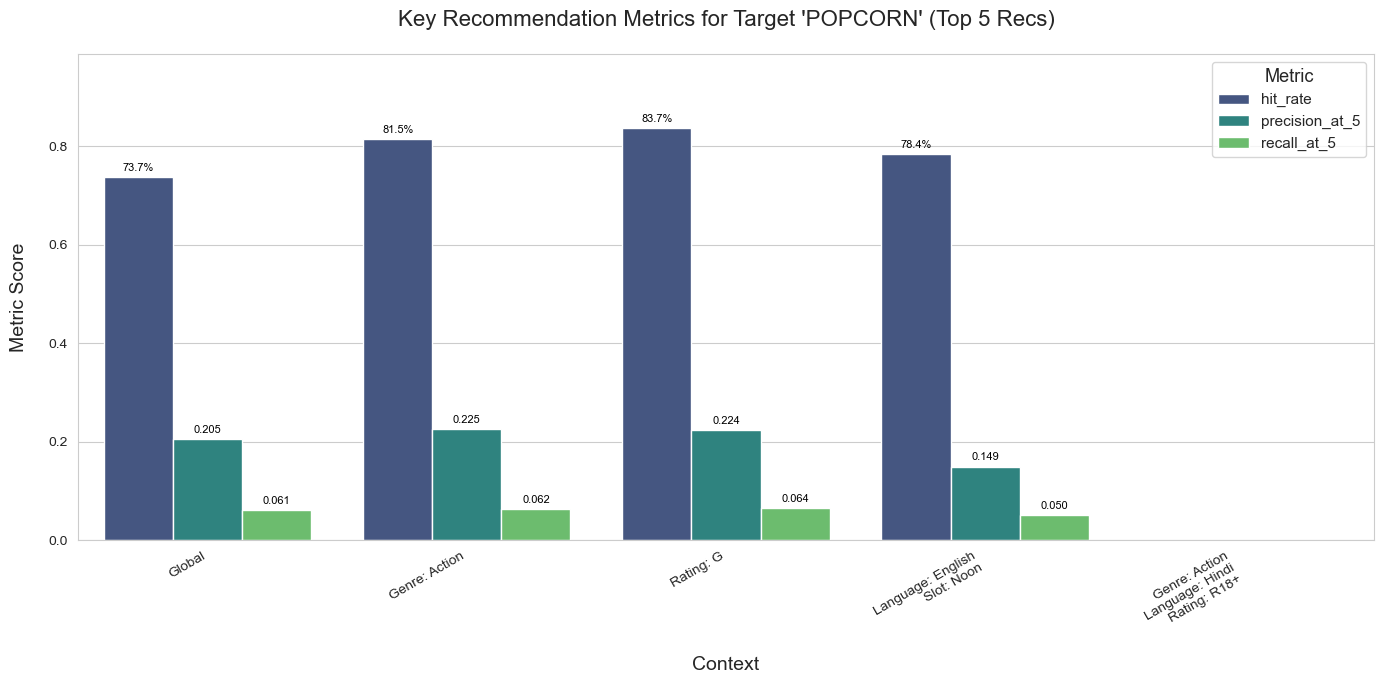

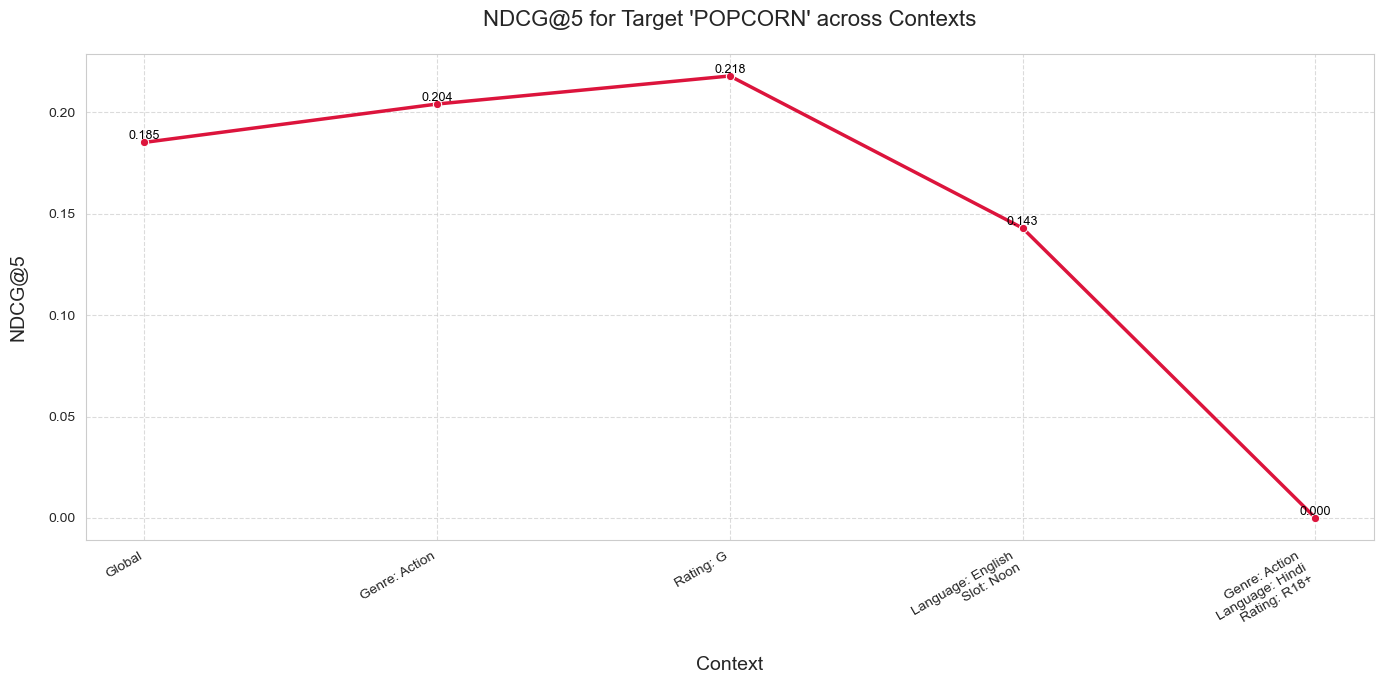


--- 2. Deep Dive: 'POPCORN' Recommendations in 'Action' Context ---


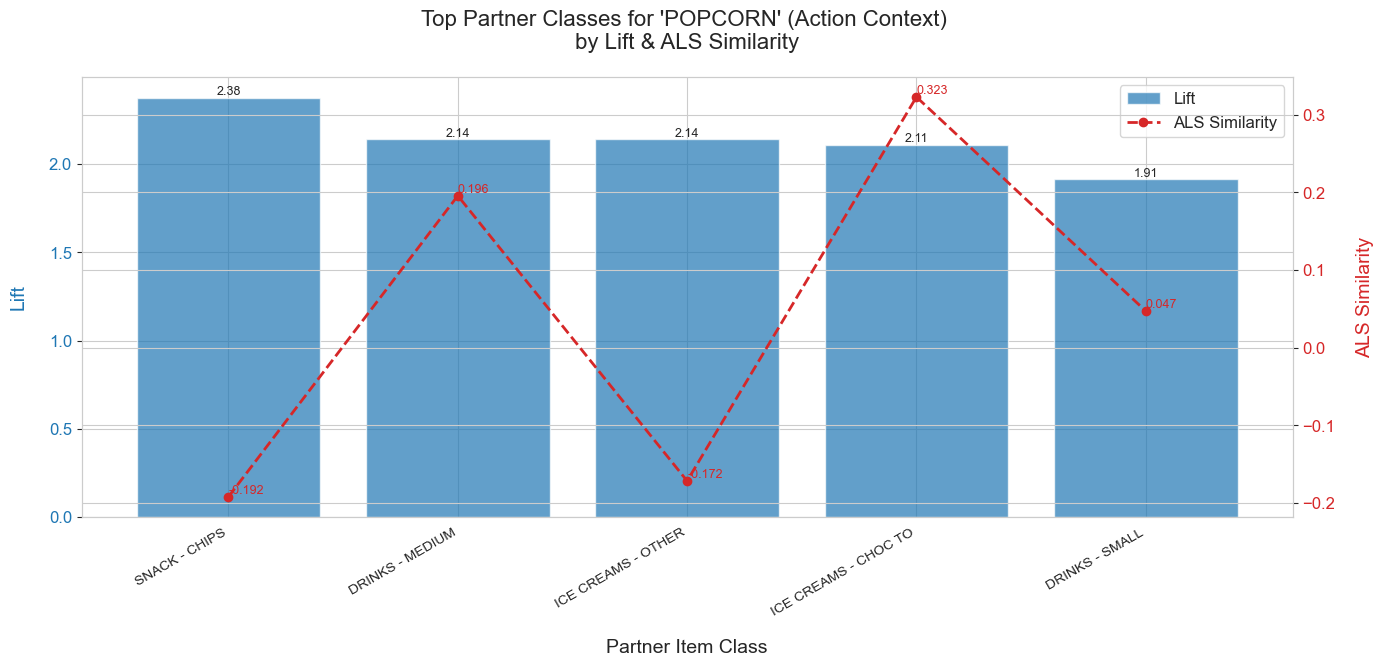

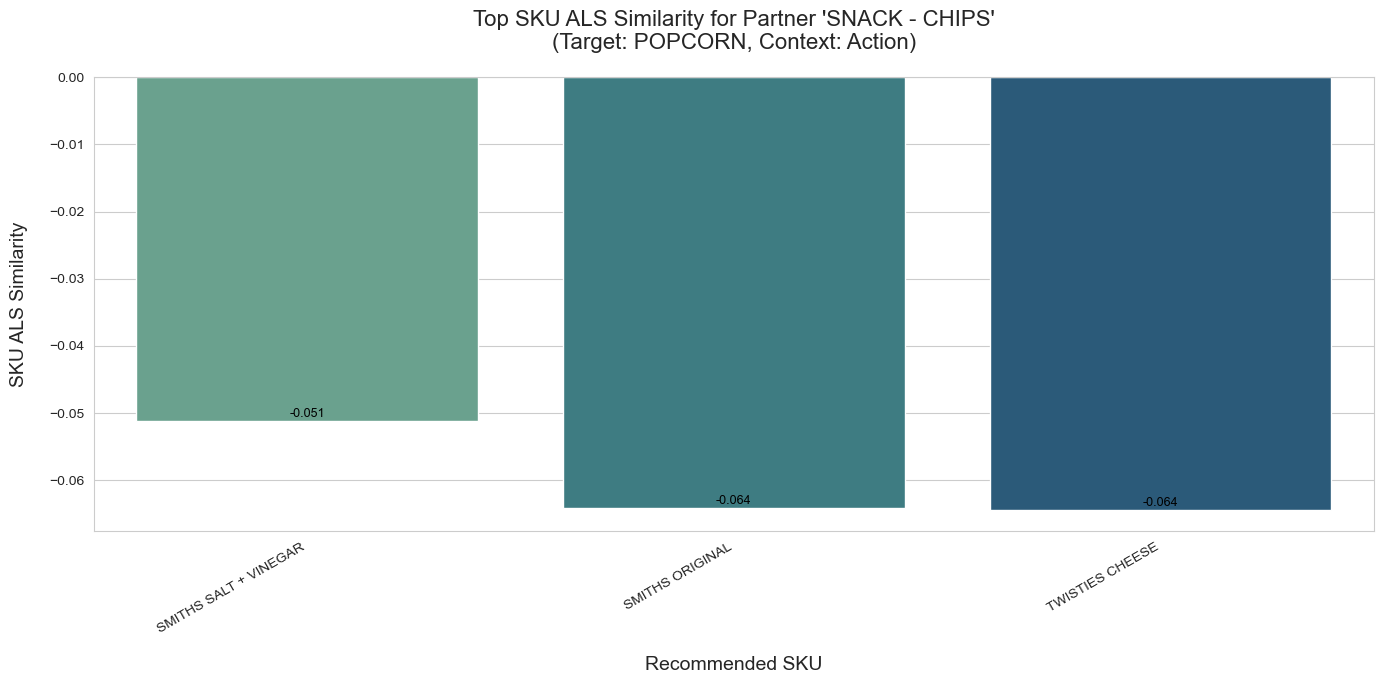


--- 3. Combo Recommendation Insights (Overall: Buy 1 Base -> Get 2 Add-on) ---


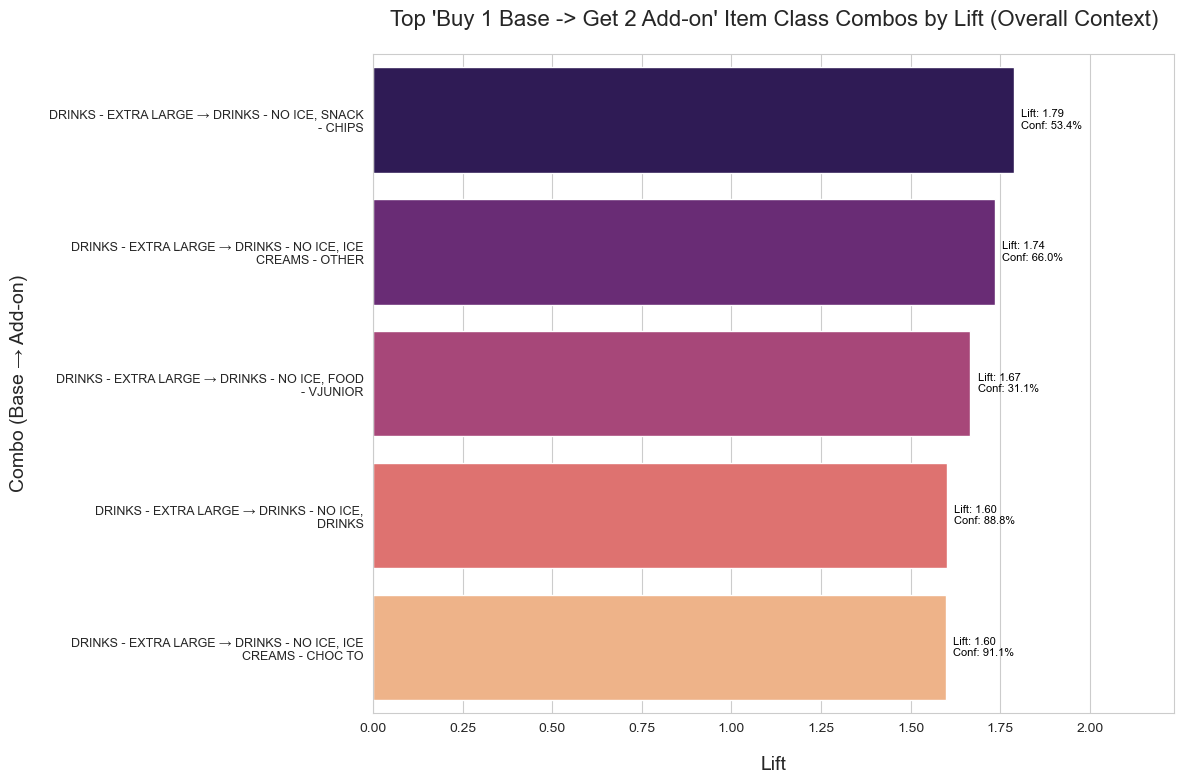


--- 4. Distribution of Partner Class ALS Scores from Master Table ---


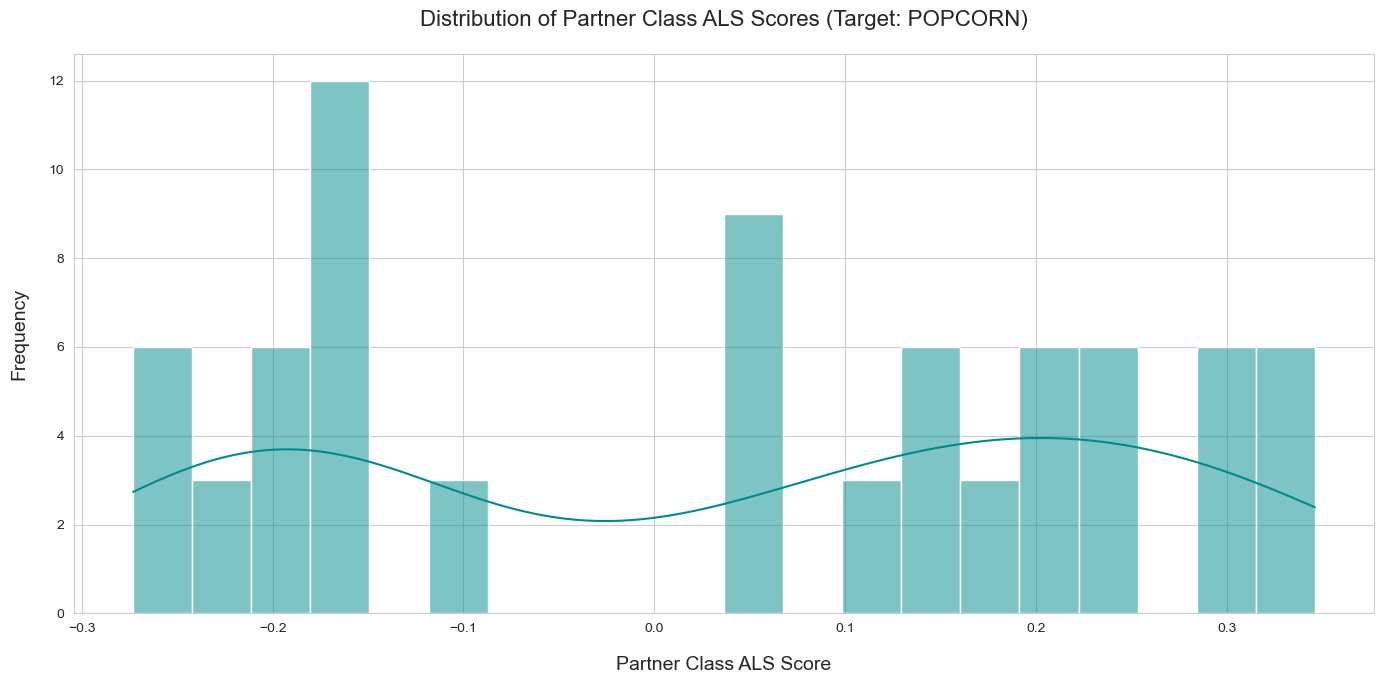

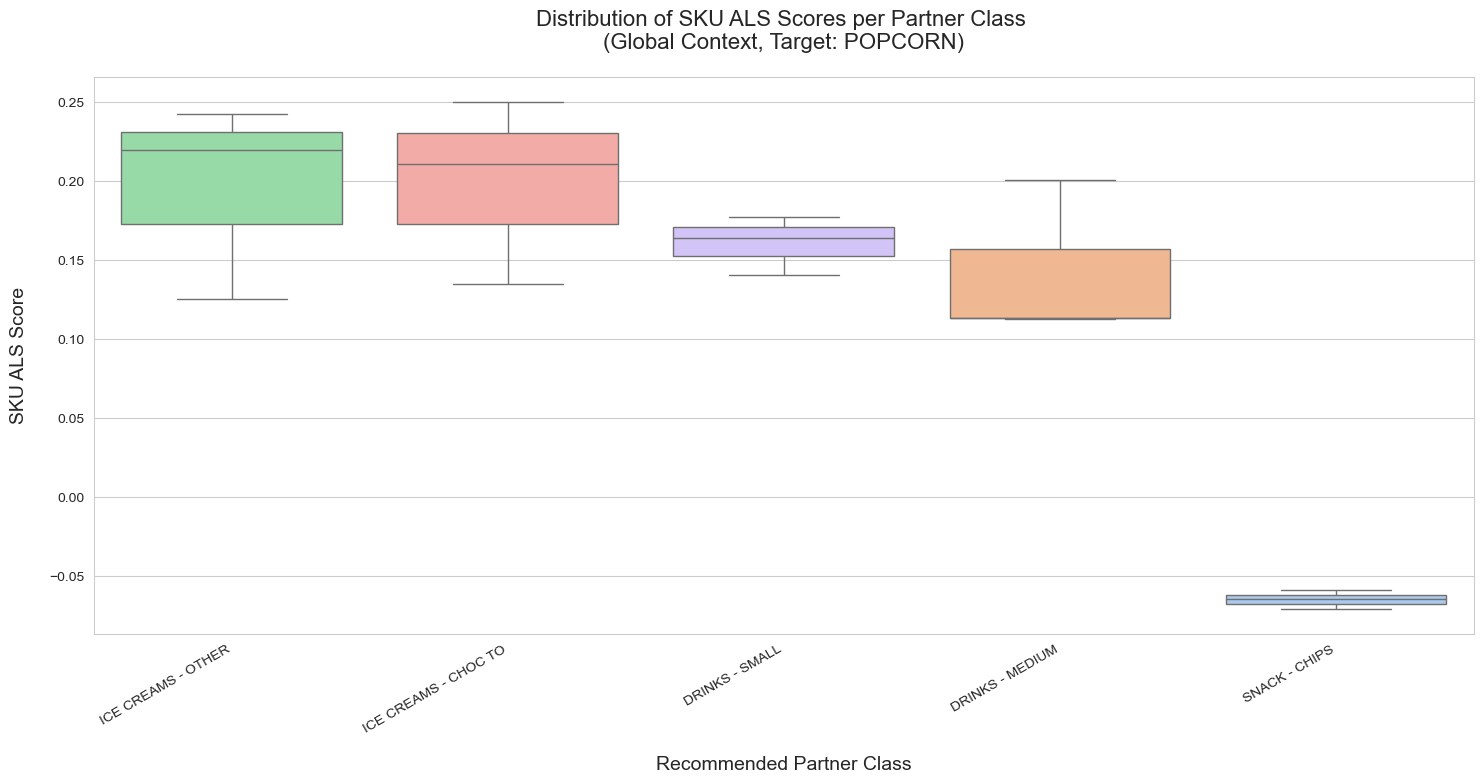


--- End of Enhanced Visualizations ---


In [17]:
# Cell 17: Enhanced Visualizations for Stakeholders

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import pandas as pd
import numpy as np
import json
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning, module="matplotlib.text")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.formatter.limits'] = -5, 5

print("\n--- Enhanced Visualizations for Stakeholder Review (Recency Weighted) ---")

if 'PRIMARY_TARGET_ITEM_DEMO' not in locals(): PRIMARY_TARGET_ITEM_DEMO = "POPCORN" # Ensure it's defined

if 'summary_df_demo_v2' in locals() and isinstance(summary_df_demo_v2, pd.DataFrame) and not summary_df_demo_v2.empty:
    print("\n--- 1. Recommendation Performance Across Contexts ---")
    df_perf = summary_df_demo_v2.copy()
    
    def shorten_context(desc):
        if desc == "Global (No Context)": return "Global"
        try:
            if isinstance(desc, str) and desc.startswith("{") and desc.endswith("}"):
                ctx_dict = json.loads(desc)
                return "\n".join([f"{k}: { (','.join(map(str,v)) if isinstance(v,list) else str(v)) }" for k,v in ctx_dict.items()])
            return textwrap.fill(str(desc), width=25)
        except json.JSONDecodeError:
            return textwrap.fill(str(desc), width=25)

    df_perf['short_context'] = df_perf['context_description'].apply(shorten_context)
    
    k_val_for_plot = 5
    valid_k_values = df_perf["k_for_metrics_calc"].dropna()
    if not valid_k_values.empty:
        k_val_for_plot = int(valid_k_values.iloc[0])

    precision_col = f"precision_at_{k_val_for_plot}"
    recall_col = f"recall_at_{k_val_for_plot}"
    ndcg_col = f"ndcg_at_{k_val_for_plot}"

    metrics_to_plot = ['hit_rate', precision_col, recall_col]
    existing_metrics_to_plot = [m for m in metrics_to_plot if m in df_perf.columns]

    if existing_metrics_to_plot:
        df_melted = pd.melt(df_perf, id_vars=['short_context'], value_vars=existing_metrics_to_plot,
                            var_name='Metric', value_name='Score')
        df_melted['Score'] = pd.to_numeric(df_melted['Score'], errors='coerce')
        df_melted.dropna(subset=['Score'], inplace=True)

        if not df_melted.empty:
            plt.figure()
            ax = sns.barplot(data=df_melted, x='short_context', y='Score', hue='Metric', palette='viridis')
            plt.title(f"Key Recommendation Metrics for Target '{PRIMARY_TARGET_ITEM_DEMO}' (Top {k_val_for_plot} Recs)", fontsize=16, pad=20)
            plt.xlabel("Context", fontsize=14, labelpad=15)
            plt.ylabel("Metric Score", fontsize=14, labelpad=15)
            plt.xticks(rotation=30, ha="right", fontsize=10)
            plt.yticks(fontsize=10)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, title='Metric', title_fontsize='13', fontsize='11', loc='best')

            for i, container in enumerate(ax.containers):
                metric_name_for_format = labels[i]
                for bar in container.patches:
                    height = float(bar.get_height())
                    if pd.isna(height) or abs(height) < 0.00001: continue
                    if "hit_rate" in metric_name_for_format.lower():
                        label_text = f"{height:.1%}"
                    else:
                        label_text = f"{height:.3f}"
                    ax.annotate(label_text,
                                xy=(float(bar.get_x() + bar.get_width() / 2), height),
                                xytext=(0, 3), textcoords="offset points",
                                ha='center', va='bottom', fontsize=8, color='black')
            plt.ylim(top=df_melted['Score'].max() * 1.18 if not df_melted['Score'].empty and pd.notna(df_melted['Score'].max()) else 0.1)
            plt.tight_layout()
            plt.show()
        else:
            print("Melted DataFrame for bar plot is empty or all scores are NaN.")
    else:
        print(f"None of the metrics {metrics_to_plot} found in performance summary for bar plot.")

    if ndcg_col in df_perf.columns:
        plt.figure()
        df_perf[ndcg_col] = pd.to_numeric(df_perf[ndcg_col], errors='coerce')
        df_plot_ndcg = df_perf.dropna(subset=[ndcg_col])

        if not df_plot_ndcg.empty:
            sns.lineplot(data=df_plot_ndcg, x='short_context', y=ndcg_col, marker='o', sort=False, color='crimson', linewidth=2.5)
            plt.title(f"NDCG@{k_val_for_plot} for Target '{PRIMARY_TARGET_ITEM_DEMO}' across Contexts", fontsize=16, pad=20)
            plt.xlabel("Context", fontsize=14, labelpad=15)
            plt.ylabel(f"NDCG@{k_val_for_plot}", fontsize=14, labelpad=15)
            plt.xticks(rotation=30, ha="right", fontsize=10)
            plt.yticks(fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.7)
            for _, row in df_plot_ndcg.iterrows():
                if pd.notna(row[ndcg_col]):
                    x_pos = row['short_context']
                    y_pos = float(row[ndcg_col])
                    plt.text(x_pos, y_pos, f"{y_pos:.3f}", color='black', ha="center", va="bottom", fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid data for NDCG plot after handling NaNs for column '{ndcg_col}'.")
    else:
        print(f"Column '{ndcg_col}' not found for NDCG plot.")
else:
    print("Performance summary DataFrame ('summary_df_demo_v2') not found or empty. Skipping performance visualizations.")

if 'partner_classes_df_action' in locals() and 'sku_map_action' in locals() and \
   'PRIMARY_TARGET_ITEM_DEMO' in locals() and \
   isinstance(partner_classes_df_action, pd.DataFrame) and not partner_classes_df_action.empty:
    
    print(f"\n--- 2. Deep Dive: '{PRIMARY_TARGET_ITEM_DEMO}' Recommendations in 'Action' Context ---")
    
    df_pc_action = partner_classes_df_action.copy()
    als_col_name = 'class_als_similarity'

    if 'lift' in df_pc_action.columns and als_col_name in df_pc_action.columns and 'partner_item_class' in df_pc_action.columns:
        fig, ax1 = plt.subplots()
        color_lift = 'tab:blue'
        ax1.set_xlabel('Partner Item Class', fontsize=14, labelpad=15)
        ax1.set_ylabel('Lift', color=color_lift, fontsize=14, labelpad=15)
        df_pc_action['lift'] = pd.to_numeric(df_pc_action['lift'], errors='coerce')
        plot_df_pc_lift = df_pc_action.dropna(subset=['lift', 'partner_item_class'])

        if not plot_df_pc_lift.empty:
            bars = ax1.bar(plot_df_pc_lift['partner_item_class'], plot_df_pc_lift['lift'], color=color_lift, alpha=0.7, label='Lift')
            ax1.tick_params(axis='y', labelcolor=color_lift)
            ax1.set_xticks(range(len(plot_df_pc_lift['partner_item_class'])))
            ax1.set_xticklabels(plot_df_pc_lift['partner_item_class'], rotation=30, ha="right", fontsize=10)
            for bar_patch in bars:
                yval = float(bar_patch.get_height())
                if pd.notna(yval):
                     plt.text(float(bar_patch.get_x() + bar_patch.get_width()/2.0), yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=9)

        ax2 = ax1.twinx()
        color_als = 'tab:red'
        ax2.set_ylabel(f'ALS Similarity', color=color_als, fontsize=14, labelpad=15)
        df_pc_action[als_col_name] = pd.to_numeric(df_pc_action[als_col_name], errors='coerce')
        plot_df_pc_als = df_pc_action.dropna(subset=[als_col_name, 'partner_item_class'])

        if not plot_df_pc_als.empty:
            ax2.plot(range(len(plot_df_pc_als['partner_item_class'])), plot_df_pc_als[als_col_name], color=color_als, marker='o', linestyle='--', linewidth=2, label=f'ALS Similarity')
            ax2.tick_params(axis='y', labelcolor=color_als)
            for idx_row, row_als in plot_df_pc_als.iterrows(): # Use idx_row for index
                if pd.notna(row_als[als_col_name]):
                    try:
                        text_x_pos = list(plot_df_pc_lift['partner_item_class']).index(row_als['partner_item_class'])
                        ax2.text(text_x_pos, float(row_als[als_col_name]), f"{float(row_als[als_col_name]):.3f}", color=color_als, ha="left", va="bottom", fontsize=9)
                    except ValueError: pass
        fig.tight_layout(rect=[0, 0.05, 1, 0.93])
        plt.title(f"Top Partner Classes for '{PRIMARY_TARGET_ITEM_DEMO}' (Action Context) \nby Lift & ALS Similarity", fontsize=16, pad=20)
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        if handles1 or handles2: ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')
        plt.show()
    else:
        print("Required columns for deep dive plot not found in 'partner_classes_df_action'.")

    if sku_map_action and isinstance(sku_map_action, dict):
        first_partner_with_skus = None
        first_skus_df = None
        ordered_partners_from_df = df_pc_action['partner_item_class'].tolist() if 'partner_item_class' in df_pc_action.columns else list(sku_map_action.keys())
        for partner_name in ordered_partners_from_df:
            if partner_name in sku_map_action and isinstance(sku_map_action[partner_name], pd.DataFrame) and not sku_map_action[partner_name].empty:
                first_partner_with_skus = partner_name
                first_skus_df = sku_map_action[partner_name].copy()
                break
        
        if first_partner_with_skus and first_skus_df is not None:
            plt.figure()
            sku_als_col = 'sku_als_similarity'
            if sku_als_col in first_skus_df.columns and 'recommended_sku_name' in first_skus_df.columns:
                first_skus_df[sku_als_col] = pd.to_numeric(first_skus_df[sku_als_col], errors='coerce')
                plot_df_skus = first_skus_df.dropna(subset=[sku_als_col])
                if not plot_df_skus.empty:
                    ax_sku = sns.barplot(data=plot_df_skus, x="recommended_sku_name", y=sku_als_col, 
                                         hue="recommended_sku_name", palette="crest", legend=False)
                    plt.title(f"Top SKU ALS Similarity for Partner '{first_partner_with_skus}'\n(Target: {PRIMARY_TARGET_ITEM_DEMO}, Context: Action)", fontsize=16, pad=20)
                    plt.xlabel("Recommended SKU", fontsize=14, labelpad=15)
                    plt.ylabel("SKU ALS Similarity", fontsize=14, labelpad=15)
                    plt.xticks(rotation=30, ha="right", fontsize=10); plt.yticks(fontsize=10)
                    for p_bar in ax_sku.patches:
                        height = float(p_bar.get_height())
                        if pd.notna(height):
                            ax_sku.annotate(f"{height:.3f}",
                                        (float(p_bar.get_x() + p_bar.get_width() / 2.), height),
                                        ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                                        textcoords='offset points')
                    plt.tight_layout(); plt.show()
                else:
                    print(f"No valid SKU data to plot for partner '{first_partner_with_skus}'.")
            else:
                 print(f"Required columns for SKU plot not found for partner '{first_partner_with_skus}'.")
        else:
            print("No SKU data found in 'sku_map_action' for detailed partner visualization.")
else:
    print("Data for 'Action' context recommendations not found. Skipping deep dive visualizations.")

if 'overall_combos_b1g2_df' in locals() and isinstance(overall_combos_b1g2_df, pd.DataFrame) and not overall_combos_b1g2_df.empty:
    print("\n--- 3. Combo Recommendation Insights (Overall: Buy 1 Base -> Get 2 Add-on) ---")
    df_combo = overall_combos_b1g2_df.copy()
    base_col = 'combo_base_items'
    addon_col = 'combo_add_on_item'

    if base_col in df_combo.columns and addon_col in df_combo.columns and 'lift' in df_combo.columns and 'confidence' in df_combo.columns:
        df_combo['full_combo_str'] = df_combo[base_col].astype(str) + " → " + df_combo[addon_col].astype(str)
        df_combo['full_combo_str_wrapped'] = df_combo['full_combo_str'].apply(lambda x: textwrap.fill(x, width=45))
        df_combo['lift'] = pd.to_numeric(df_combo['lift'], errors='coerce')
        df_combo['confidence'] = pd.to_numeric(df_combo['confidence'], errors='coerce')
        plot_df_combo = df_combo.dropna(subset=['lift', 'confidence'])

        if not plot_df_combo.empty:
            plt.figure(figsize=(12,8))
            ax_combo = sns.barplot(data=plot_df_combo.head(10), y='full_combo_str_wrapped', x='lift', 
                                   hue='full_combo_str_wrapped', palette='magma', orient='h', legend=False)
            plt.title(f"Top 'Buy 1 Base -> Get 2 Add-on' Item Class Combos by Lift (Overall Context)", fontsize=16, pad=20)
            plt.xlabel("Lift", fontsize=14, labelpad=15)
            plt.ylabel("Combo (Base → Add-on)", fontsize=14, labelpad=15)
            plt.xticks(fontsize=10); plt.yticks(fontsize=9)
            for i, bar_patch in enumerate(ax_combo.patches):
                value = float(bar_patch.get_width())
                confidence_val = float(plot_df_combo.head(10)['confidence'].iloc[i])
                if pd.notna(value) and pd.notna(confidence_val):
                    label_text = f"Lift: {value:.2f}\nConf: {confidence_val:.1%}"
                    ax_combo.text(value + 0.02, float(bar_patch.get_y() + bar_patch.get_height() / 2), 
                                  label_text, va='center', ha='left', fontsize=8, color='black')
            max_lift = plot_df_combo['lift'].max()
            plt.xlim(right=max_lift * 1.25 if pd.notna(max_lift) and max_lift > 0 else 1.5)
            plt.tight_layout(); plt.show()
        else:
            print("No valid data for combo plot after handling NaNs.")
    else:
        print("Required columns for combo plot not found in 'overall_combos_b1g2_df'.")
else:
    print("Combo DataFrame ('overall_combos_b1g2_df') not found or empty. Skipping combo visualizations.")

if 'master_table_demo_v2' in locals() and isinstance(master_table_demo_v2, pd.DataFrame) and not master_table_demo_v2.empty:
    print("\n--- 4. Distribution of Partner Class ALS Scores from Master Table ---")
    df_master = master_table_demo_v2.copy()
    als_partner_col = 'partner_class_als_score'

    if als_partner_col in df_master.columns:
        als_scores_partner = pd.to_numeric(df_master[als_partner_col], errors='coerce').dropna()
        if not als_scores_partner.empty:
            plt.figure()
            sns.histplot(als_scores_partner, kde=True, color='darkcyan', bins=20)
            plt.title(f"Distribution of Partner Class ALS Scores (Target: {PRIMARY_TARGET_ITEM_DEMO})", fontsize=16, pad=20)
            plt.xlabel("Partner Class ALS Score", fontsize=14, labelpad=15)
            plt.ylabel("Frequency", fontsize=14, labelpad=15)
            plt.xticks(fontsize=10); plt.yticks(fontsize=10)
            plt.tight_layout(); plt.show()
            
            global_context_key = '{\"comment\": \"Global/No_Context\"}'
            df_global_recs = df_master[df_master['context_json_representation'] == global_context_key].copy()
            sku_als_col_master = 'partner_sku_als_score'
            partner_col_master = 'recommended_partner_class'

            if sku_als_col_master in df_global_recs.columns and partner_col_master in df_global_recs.columns:
                df_global_recs[sku_als_col_master] = pd.to_numeric(df_global_recs[sku_als_col_master], errors='coerce')
                df_global_recs.dropna(subset=[partner_col_master, sku_als_col_master], inplace=True)
                df_global_recs = df_global_recs[~df_global_recs[partner_col_master].astype(str).str.contains("NO_PARTNER|ERROR", na=False)]

                if not df_global_recs.empty:
                    unique_partners = df_global_recs[partner_col_master].unique()
                    if len(unique_partners) > 10:
                        top_partners_for_boxplot = df_global_recs[partner_col_master].value_counts().nlargest(7).index
                        df_plot_skus_master = df_global_recs[df_global_recs[partner_col_master].isin(top_partners_for_boxplot)]
                        boxplot_title_suffix = "(Top 7 Partners by Freq.)"
                    else:
                        df_plot_skus_master = df_global_recs
                        boxplot_title_suffix = ""

                    if not df_plot_skus_master.empty:
                        plt.figure(figsize=(15,8))
                        sns.boxplot(data=df_plot_skus_master, x=partner_col_master, y=sku_als_col_master, 
                                    hue=partner_col_master, palette='pastel', legend=False,
                                    order = df_plot_skus_master.groupby(partner_col_master)[sku_als_col_master].median().sort_values(ascending=False).index)
                        plt.title(f"Distribution of SKU ALS Scores per Partner Class {boxplot_title_suffix}\n(Global Context, Target: {PRIMARY_TARGET_ITEM_DEMO})", fontsize=16, pad=20)
                        plt.xlabel("Recommended Partner Class", fontsize=14, labelpad=15)
                        plt.ylabel("SKU ALS Score", fontsize=14, labelpad=15)
                        plt.xticks(rotation=30, ha="right", fontsize=10)
                        plt.yticks(fontsize=10)
                        plt.tight_layout(); plt.show()
                    else:
                        print("Not enough data for SKU ALS score boxplot from master table.")
                else:
                    print("No valid global context recommendations in master table for SKU boxplot.")
            else:
                print("Required columns for SKU ALS score boxplot not found in master table's global data.")
        else:
            print("No valid Partner Class ALS scores in master table for distribution plot.")
    else:
        print(f"Column '{als_partner_col}' for partner ALS scores not found in master table.")
else:
    print("Master decision table ('master_table_demo_v2') not found or empty. Skipping master table visualizations.")

print("\n--- End of Enhanced Visualizations ---")